# January, 14th 2020

**Motivation**: Combining datasets using Canonical Correlation Analysis (CCA). Can we find shared latent dimensions that have large correlation across datasets?  By mapping data from neuron space to this common latent space, we can combine data across experiments for the classification analysis. <br>
**Result**: Preliminary results show that this is possible.  Thorough analysis is needed to understand the nature and content of this space.

In [1]:
# HIDE CODE


# imports
import os
import sys
import h5py
import pickle
import random
import numpy as np
import pandas as pd
from os.path import join as pjoin
from copy import deepcopy as dc
from tqdm.notebook import tqdm
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

github_path = pjoin(os.environ['HOME'], 'Dropbox/git/A1ToneDiscrimination/')
sys.path.insert(0, github_path)
from utils.process import *
from utils.generic_utils import *
from utils.plot_functions import *

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

import rcca
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef, f1_score

from analysis.cca_analysis import *

# load data
dirs_dict = get_dirs()

## CCA analysis

Here I will first briefly review the data structure we have.  Then, I will describe how CCA can be used to combine these datasets, despite dimensionality mismatch that has bugged us for a long time.

### Data structure

We have 34 experiments, each with different number of trials and different number of neurons.  The data for each experiment is organized as follows:

$$X_\mu \in \mathbb{R}^{nt \,\times\, ntrials_\mu \,\times\, nc_\mu},$$

where we have:

- $X_\mu$ is DFF traces for experiment indexed by $\mu$ (I will use greek indices such as $\mu$ to index experiments).  Therefore, using this notation, the followig set contains all the data $\{X_\mu | \mu \in 0\dots33\}$.
- All experiments have the same $nt = 135$ time points that corresponds to a duration of $135/30 = 4.5$ s, since data acquisition frequency was $30$ Hz.
- Each experiment has potentially different number of trials, $ntrials_\mu$.  These trials are labeled as hit or miss and so on.  Stimulus frequency presented during these trials is another variable that we can use to align trials.
- Each experimenta has different number of neurons, $nc_\mu$.  Crucially, these neurons are ordered arbitrarily and there are no a priori correspondence between neuron $i$ from experiment $\mu$ to neuron $i$ from experiment $\nu$.

One of the main challenges has been combining these datasets by overcoming the dimensionality problem.  To do this, we need to find a common space with the same dimensionality and meaning shared across all experiments.  In this space, dimension $i$ has a fixed meaning.  In contrast, in neuron space this does not exist.  It turns out we can use CCA to address this issue.

### Canonical correlation analysis (CCA)

For simplicity, imagine we only had two datasets, $X_1$ and $X_2$ with $nc_1$ amd $nc_2$ number of neurons. Let's assume for now that these both experiments have $100$ total number of trials: $50$ hit and $50$ miss. As another simplification, let's assume we are only interested in a timepoint $t = 45$.  Under these assumptions, we have $X_1 \in \mathbb{R}^{100 \,\times\, nc_1}$, and $X_2 \in \mathbb{R}^{100 \,\times\, nc_2}$.  The goal is to find vectors $a_1 \in \mathbb{R}^{nc_1 \,\times\, K}$, and $a_2 \in \mathbb{R}^{nc_2 \,\times\, K}$ that map the data from neuron space into a $K-$dimensional canonical space.  Define:

$$U = X_1 a_1 \in \mathbb{R}^{100 \,\times\, K}, \,\, \text{and } \,\, V = X_2 a_2 \in \mathbb{R}^{100 \,\times\, K},$$

where $U$ and $V$ are called *canonical variates*.  The obkective function of CCA is to find a set of loading vectors $a_\mu$ that maximize correlation between canonical variates:

$$\rho = \text{corr}(U, V) = \text{corr}(X_1 a_1, X_2 a_2).$$

In [7]:
output_trn, output_tst = prepare_cca_data(
    h_load_file=dirs_dict['h_load_file'],
    min_nb_trials=100,
    target=True,
    global_normalize=True,
    augment_data=False,
    xv_folds=5,
    which_fold=0,
    time_range=range(45, 51),
    verbose=True,
)

scabbers_2016-08-31 (135, 100, 67)
scabbers_2016-09-07 (135, 124, 65)
scabbers_2016-09-22 (135, 133, 73)
scabbers_2016-09-23 (135, 110, 62)
scabbers_2016-09-28 (135, 134, 52)


In [8]:
[item.shape for item in output_trn['processed']]

[(486, 67), (486, 65), (486, 73), (486, 62), (486, 52)]

In [9]:
[item.shape for item in output_trn['raw'].values()]

[(6, 81, 67), (6, 101, 65), (6, 108, 73), (6, 89, 62), (6, 109, 52)]

In [10]:
[item.shape for item in output_tst['raw'].values()]

[(6, 19, 67), (6, 23, 65), (6, 25, 73), (6, 21, 62), (6, 25, 52)]

In [11]:
output_tst['labels']

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

In [4]:
global_mean = np.mean([item.std() for item in output_trn['raw'].values()])
global_std = np.mean([item.std() for item in output_trn['raw'].values()])
global_mean, global_std

(1.01029751545895, 1.01029751545895)

In [6]:
train_list = output_trn['processed']
y_trn = output_trn['labels']
test_list = output_tst['processed']
y_tst = output_tst['labels']

y_trn.shape, y_tst.shape

((405,), (95,))

In [7]:
sum(y_trn) / len(y_trn), sum(y_tst) / len(y_tst)

(0.4469135802469136, 0.4631578947368421)

In [8]:
import rcca
from tqdm.notebook import tqdm

regs = np.logspace(-8, 2, num=20)
num_ccs = np.arange(1, 101, 1)

r_all = np.zeros((len(regs), len(num_ccs)))
for j, num_cc in tqdm(enumerate(num_ccs), total=len(num_ccs)):
    for i, reg in enumerate(regs):
        cca = rcca.CCA(
            kernelcca=True,
            ktype='linear',
            reg=reg,
            numCC=num_cc,
            verbose=False,
        )
        cca.train([item / np.sqrt(num_cc) for item in train_list])
        testcorrs = cca.validate(test_list)
        
        corrs = []
        for item in testcorrs:
            corrs.append(np.mean(np.abs(item)))
        pred_r = np.mean(corrs)
        r_all[i, j] = pred_r

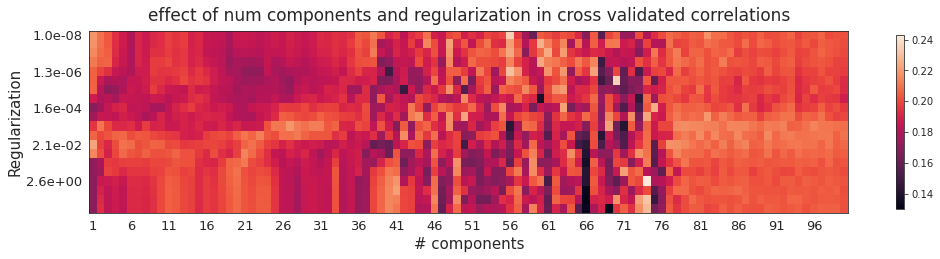

In [39]:
sns.set_style('white')
plt.figure(figsize=(17, 8))
plt.imshow(r_all, aspect=1.2)
plt.colorbar(shrink=0.4)
plt.xlabel('# components', fontsize=15)
plt.ylabel('Regularization', fontsize=15)
xticks = range(0, len(num_ccs), 5)
yticks = range(0, len(regs), 4)
plt.xticks(ticks=xticks, labels=[num_ccs[i] for i in xticks], fontsize=13)
plt.yticks(ticks=yticks, labels=['{:.1e}'.format(regs[i]) for i in yticks], fontsize=13)
plt.title('effect of num components and regularization in cross validated correlations', fontsize=17, y=1.02)
plt.show()

In [40]:
a, b = np.unravel_index(np.argmax(r_all), r_all.shape)
best_reg = regs[a]
best_cc = num_ccs[b]
best_reg, best_cc, r_all[a, b]

(2.6366508987303554, 74, 0.24313643382806155)

In [11]:
best_reg = 2.6366508987303554
best_cc = 74

cca = rcca.CCA(
    kernelcca=True,
    ktype='linear',
    reg=best_reg,
    numCC=best_cc,
    verbose=False,
)
cca.train([item / np.sqrt(best_cc) for item in train_list])
testcorrs = cca.validate(test_list)

corrs = []
for item in testcorrs:
    corrs.append(np.mean(np.abs(item)))
pred_r = np.mean(corrs)
pred_r

0.24313643382806155

In [95]:
[item.std() for item in cca.comps]

[1.4169573198262593,
 1.7906731089748553,
 2.7504465243516543,
 2.5812042862362,
 2.663279500990638]

In [96]:
[item.std() for item in cca.ws]

[0.4266867512017132,
 0.4622012546793848,
 0.5499353578117441,
 0.5912375560806967,
 0.6201057189628766]

In [97]:
x_trn = [x @ w for x, w in zip(train_list, cca.ws)]
x_tst = [x @ w for x, w in zip(test_list, cca.ws)]
x_trn, x_tst = tuple(map(np.concatenate, [x_trn, x_tst]))
x_trn.shape, x_tst.shape

((405, 79), (95, 79))

In [98]:
comps = np.concatenate(cca.comps)
comps.shape, x_trn.shape

((405, 79), (405, 79))

In [99]:
from scipy.stats import pearsonr
pearsonr(comps[:, 70], x_trn[:, 70])

(1.0, 0.0)

In [100]:
np.var(comps[:, 0]), np.var(x_trn[:, 0])

(0.3478161230929137, 27.47747372434018)

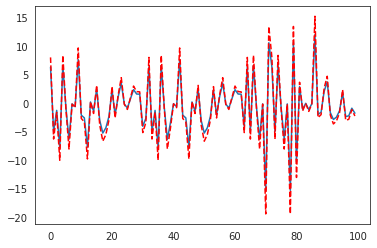

In [101]:
plt.plot(comps[:100, 0] * 7)
plt.plot(x_trn[:100, 0], 'r--')

In [22]:
from sklearn.metrics import matthews_corrcoef, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression

In [23]:
mcc_list = []

clf_regs = np.logspace(-2.7, 0.8, 2000)

for C in clf_regs:
    clf = LogisticRegression(
        penalty='l1',
        C=C,
        solver='liblinear',
        class_weight='balanced',
        max_iter=1000,
        random_state=42,
    ).fit(x_trn, y_trn)
    y_pred = clf.predict(x_tst)

    balacc = balanced_accuracy_score(y_tst, y_pred)
    mcc = matthews_corrcoef(y_tst, y_pred)
    mcc_list.append(mcc)
    # print(C, balacc, mcc)

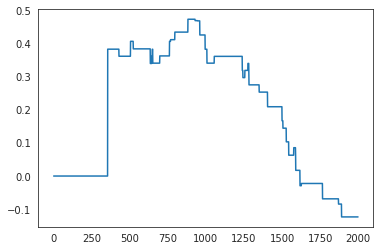

In [24]:
plt.plot(mcc_list)

In [25]:
idx = np.argmax(mcc_list)
idx, mcc_list[idx], clf_regs[idx]

(882, 0.47422390835467176, 0.06986700650984254)

## Lessons learned:

1) Normalizing, both local, and global, helps CCA<br>
2) Normalizing helps clf as well

In [29]:
best_clf_reg = 0.0699

clf = LogisticRegression(
    penalty='l1',
    C=best_clf_reg,
    solver='liblinear',
    class_weight='balanced',
    max_iter=int(1e4),
    tol=1e-5,
    random_state=42,
).fit(x_trn, y_trn)
y_pred = clf.predict(x_tst)

balacc = balanced_accuracy_score(y_tst, y_pred)
mcc = matthews_corrcoef(y_tst, y_pred)

balacc, mcc

(0.7377450980392157, 0.47422390835467176)

### TODO: 

- it seems like normalizing, both globally and locally helps CCA.  But do you need to normalize in CLF as well?
- run a test below and find out. you have comparison point for when things were normalized, not run CCA with nromalized, but add another paragraph to regenerate data trn test etc without normalization and feed that into clf! see if this helps. Porbably will not tho

In [2]:
results = pd.read_pickle('./results_night.df')
best = extract_best_hyperparams(results, 'mcc')

best hyperparams:

n_components:	81,
cca_reg:	7.386e-03,
clf_reg:	4.717e-03,
pred_r:		0.1884
mcc:		0.5771




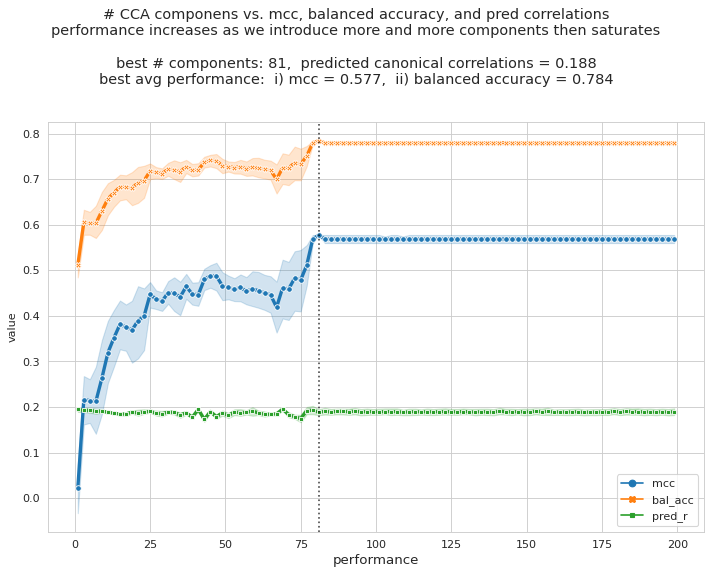

In [3]:
plot_results(results=results, best=best, figsize=(9, 7))

In [4]:
results = pd.read_pickle('./results_precision.df')
best = extract_best_hyperparams(results, 'mcc')

best hyperparams:

n_components:	81,
cca_reg:	1.017e-02,
clf_reg:	8.694e-03,
pred_r:		0.1912
mcc:		0.5814




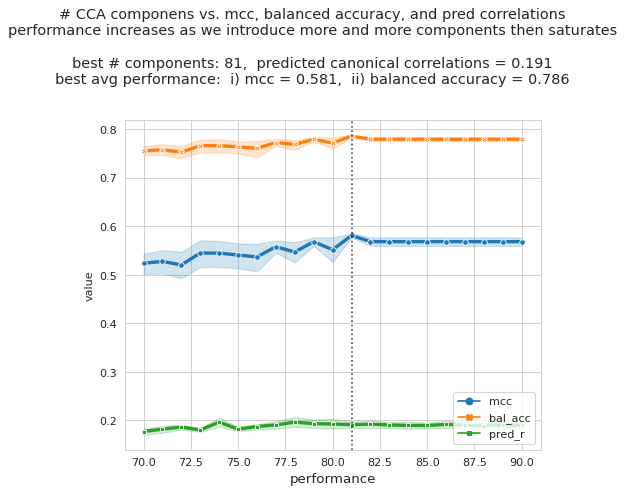

In [5]:
plot_results(results=results, best=best, figsize=(6, 6))

# --- New!

In [ ]:
### this ==> './results_(2021_01_15).df'

results, best, args = fit_cca_loop(
    h_load_file=dirs_dict['h_load_file'],
    n_seeds=3,
    num_ccs=np.arange(75, 84, 1),
    cca_regs=np.linspace(1e-4, 1e-2, 30),
    clf_regs=np.linspace(1e-3, 1e-2, 30),
)

In [2]:
results = pd.read_pickle('./results_(2021_01_15).df')
best = extract_best_hyperparams(results, 'mcc')

best hyperparams:

n_components:	79,
cca_reg:	1.000e-02,
clf_reg:	5.655e-03,
pred_r:		0.1901
mcc:		0.5782




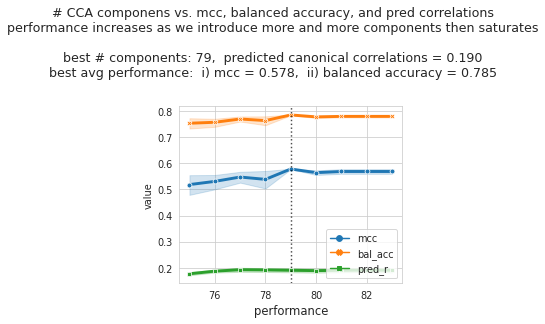

In [3]:
plot_results(results=results, best=best, figsize=(4, 4.5))

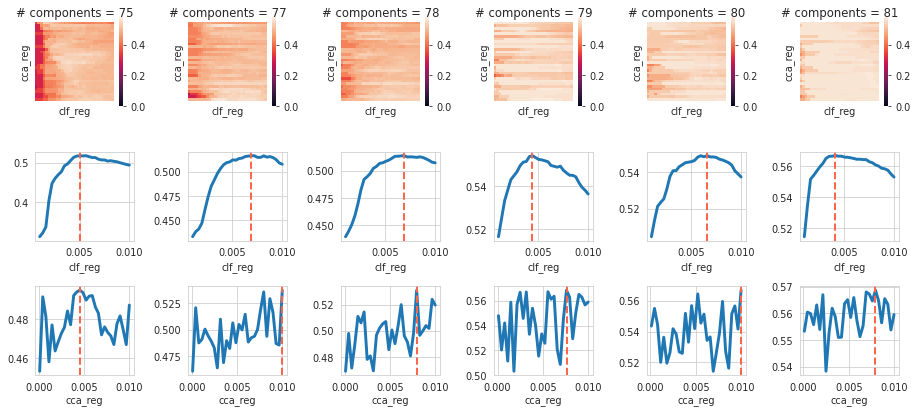

In [4]:
plot_reg_comparison(results, best, components=[75, 77, 78, 79, 80, 81], scale='linear')

## --- New!

### Study clf coefficients

In [5]:
output = get_best_cca_clf(
    h_load_file=dirs_dict['h_load_file'],
    best=best,
    min_nb_trials=100,
    time_range=range(45, 46),
    target=True,
    global_normalize=True,
    augment_data=False,
    xv_folds=5,
    which_fold=1,
    random_sate=42,
)

[PROGRESS] fitting done. results:
corr: 0.192,   balanced accuracy: 0.791,   mcc: 0.581


In [6]:
coeffs = output['clf'].coef_.flatten()
coeffs

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.06545288,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.00605412,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

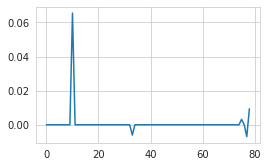

array([10, 33, 75, 77, 78])

In [7]:
sns.set_style('whitegrid')
plt.figure(figsize=(4, 2.5))
plt.plot(coeffs)
nonzero_comps = np.where(coeffs != 0)[0]
plt.show()

nonzero_comps

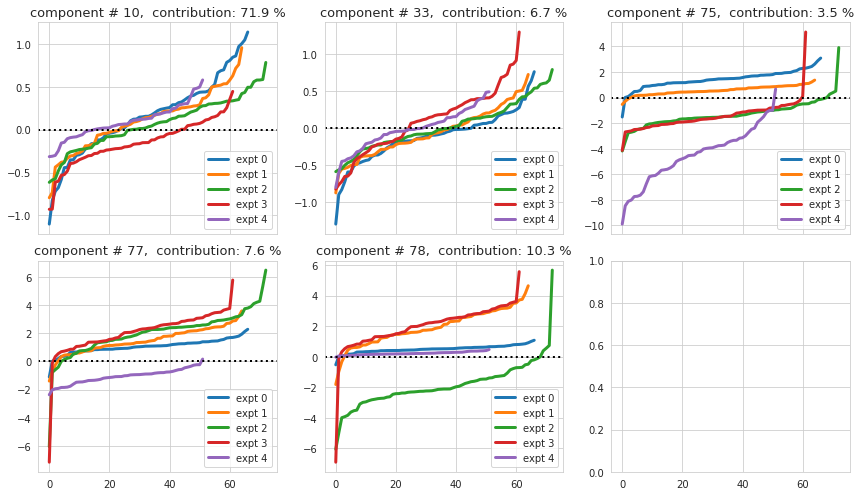

In [8]:
sns.set_style('whitegrid')
nrows = 2
ncols = int(np.ceil(len(nonzero_comps) / nrows))
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 7), sharex='all', sharey='none')

for idx, cc in enumerate(nonzero_comps):
    i, j = idx // ncols, idx % ncols

    for expt_id, w in enumerate(output['cca'].ws):
        axes[i, j].plot(sorted(w[:, cc]), lw=3, label='expt {:d}'.format(expt_id))
    axes[i, j].axhline(0, color='k', lw=2, ls=':')
    axes[i, j].legend(loc='lower right')
    msg = 'component # {:d},  contribution: {:.1f} {:s}'
    msg = msg.format(cc, abs(coeffs[cc]) / sum(abs(coeffs)) * 100, '%')
    axes[i, j].set_title(msg, fontsize=13)

fig.tight_layout()
plt.show()

In [ ]:
# flare
# Accent
# magma
# icefire

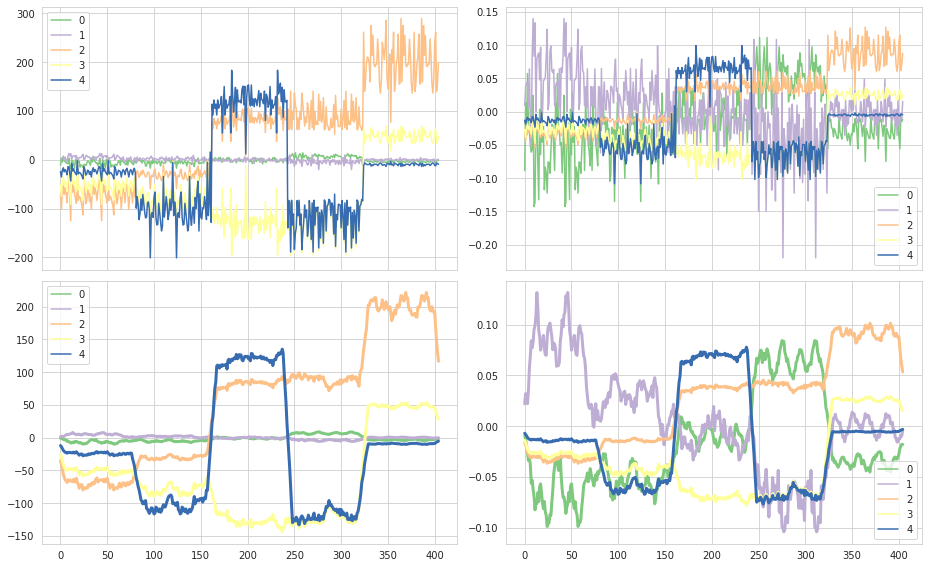

In [9]:
palette = sns.color_palette("Accent", n_colors=len(nonzero_comps))

sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(13, 8), sharex='all', sharey='none')

_data = output['comps_trn'][:, nonzero_comps]
_data_smooth = smoothen(_data.T, filter_sz=10).T
ln = sns.lineplot(data=_data, palette=palette, dashes=False, ax=axes[0, 0])
ln = sns.lineplot(data=normalize(_data, axis=0), palette=palette, dashes=False, ax=axes[0, 1])
ln = sns.lineplot(data=_data_smooth, palette=palette, lw=3, dashes=False, ax=axes[1, 0])
ln = sns.lineplot(data=normalize(_data_smooth, axis=0), palette=palette, lw=3, dashes=False, ax=axes[1, 1])

fig.tight_layout()
plt.show()

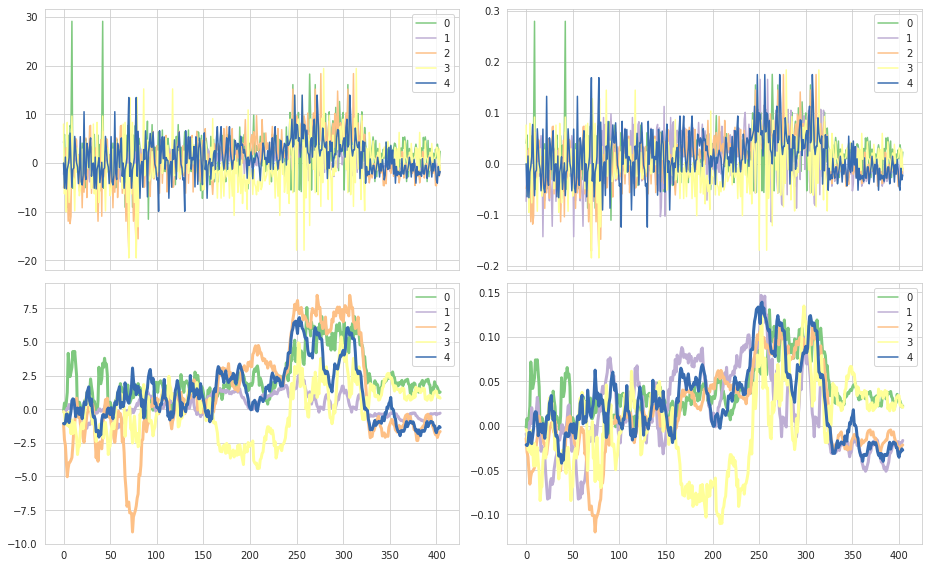

In [10]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(13, 8), sharex='all', sharey='none')

rng = np.random.RandomState(42)
zero_comps = np.where(coeffs == 0)[0]
random_components = rng.choice(zero_comps, size=len(nonzero_comps), replace=False)
_data = output['comps_trn'][:, random_components]
_data_smooth = smoothen(_data.T, filter_sz=10).T
ln = sns.lineplot(data=_data, palette=palette, dashes=False, ax=axes[0, 0])
ln = sns.lineplot(data=normalize(_data, axis=0), palette=palette, dashes=False, ax=axes[0, 1])
ln = sns.lineplot(data=_data_smooth, palette=palette, lw=3, dashes=False, ax=axes[1, 0])
ln = sns.lineplot(data=normalize(_data_smooth, axis=0), palette=palette, lw=3, dashes=False, ax=axes[1, 1])

fig.tight_layout()
plt.show()

In [11]:
from matplotlib import rcParams, cycler
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)

N = 10
data = [np.logspace(0, 1, 100) + np.random.randn(100) + ii for ii in range(N)]
data = np.array(data).T
cmap = plt.cm.coolwarm
rcParams['axes.prop_cycle'] = cycler(color=cmap(np.linspace(0, 1, N)))

fig, ax = plt.subplots()
lines = ax.plot(data)
ax.legend(lines)

SyntaxError: invalid syntax (<ipython-input-11-ae054fb20190>, line 16)

In [12]:
nonzero_comps

array([10, 33, 75, 77, 78])

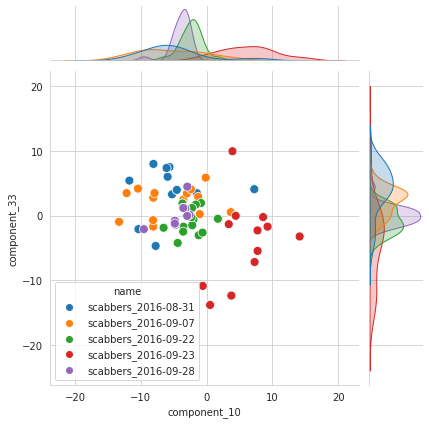

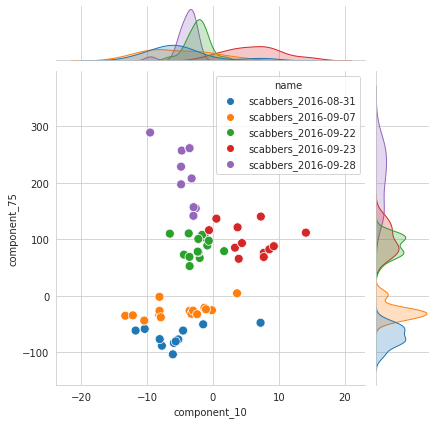

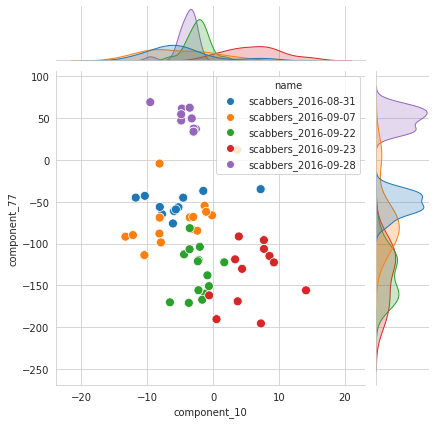

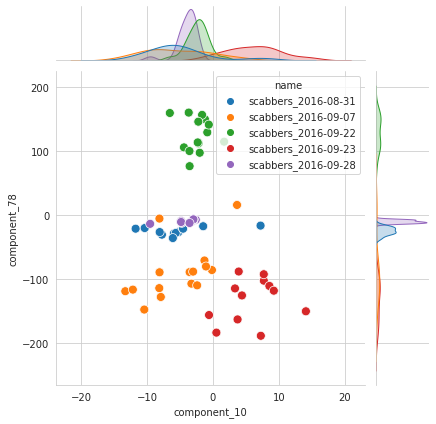

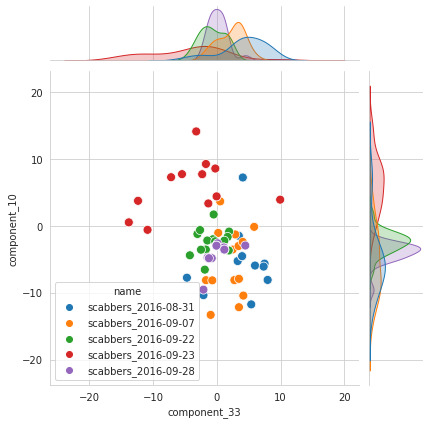

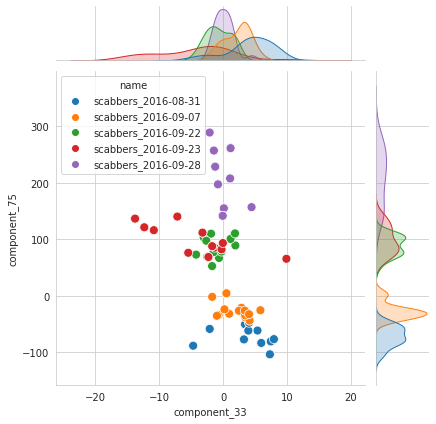

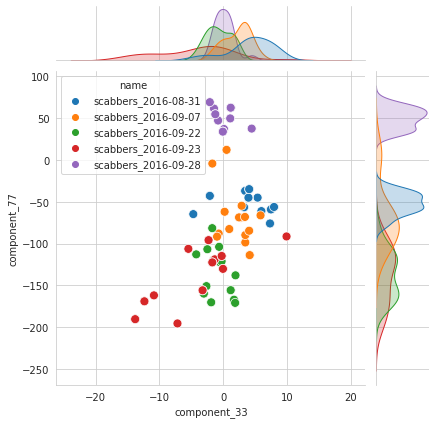

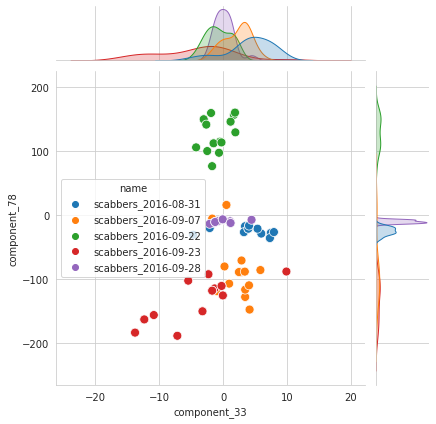

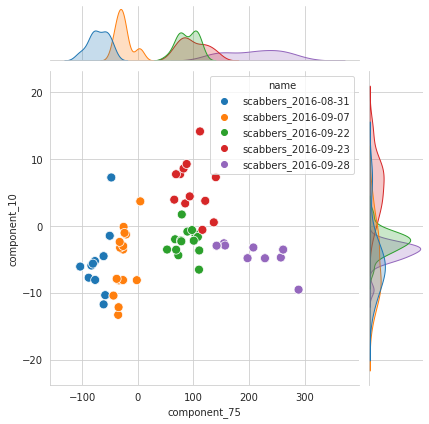

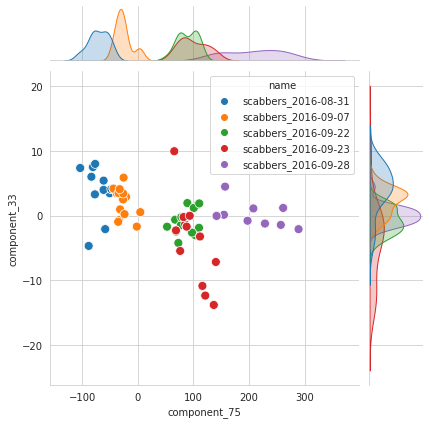

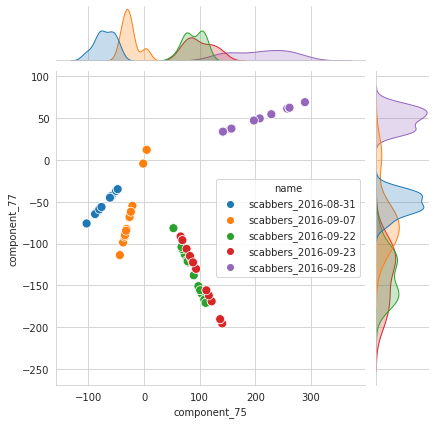

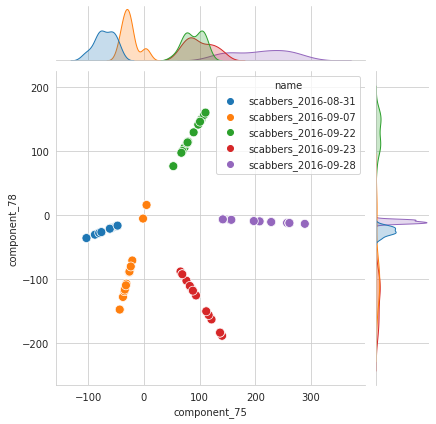

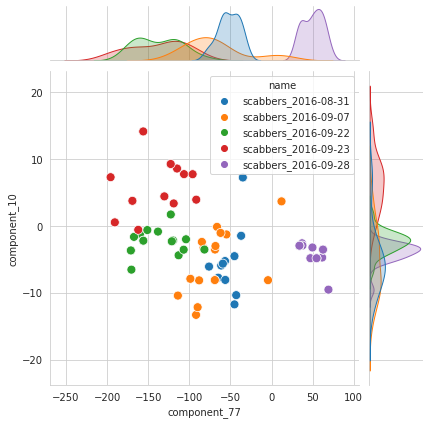

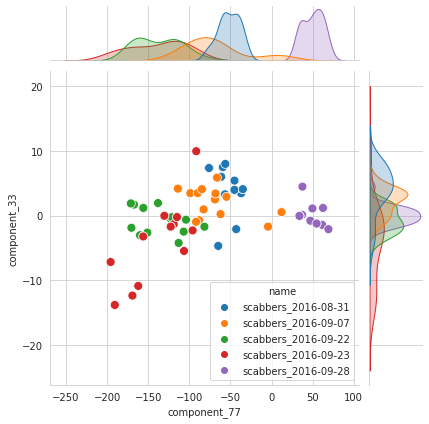

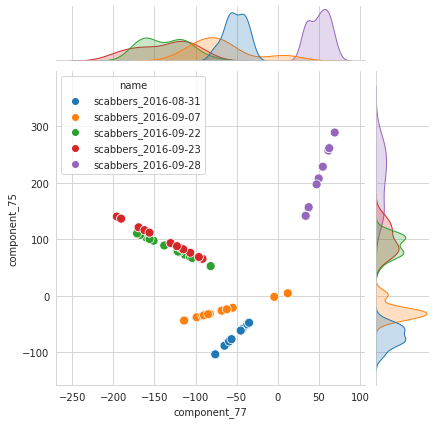

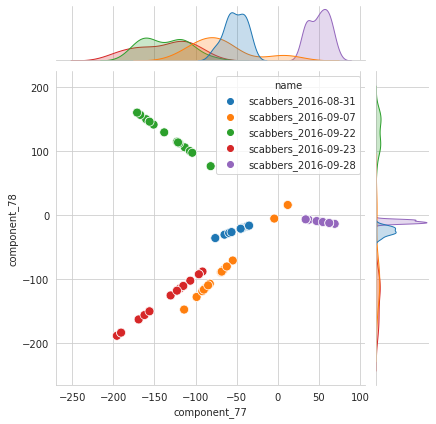

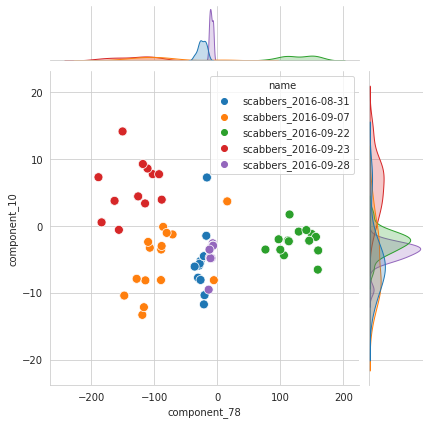

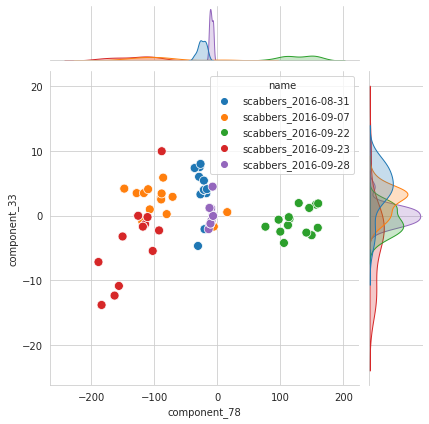

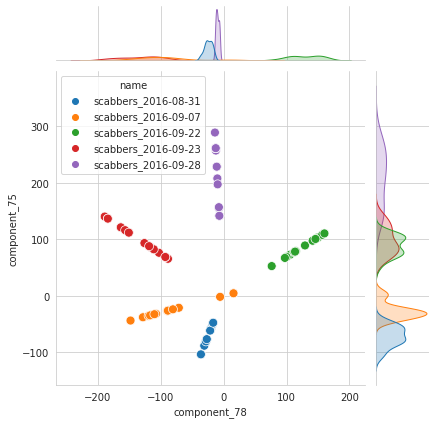

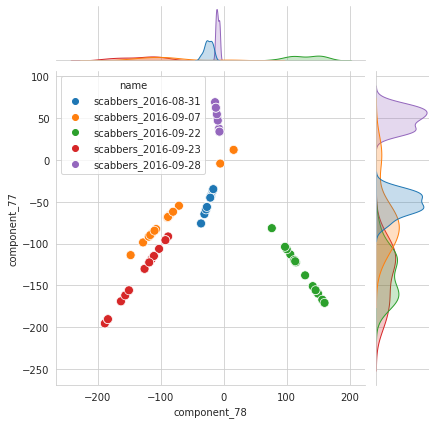

In [13]:
for c1 in nonzero_comps:
    for c2 in [item for item in nonzero_comps if item != c1]:
        sns.jointplot(
            data=output['comps_df_tst'],
            x="component_{:d}".format(c1),
            y="component_{:d}".format(c2),
            hue="name",
            kind='scatter',
            s=80,
        )
        plt.show()

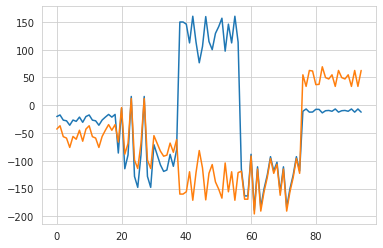

In [14]:
plt.plot(output['comps_tst'][:, 78])
plt.plot(output['comps_tst'][:, 77])

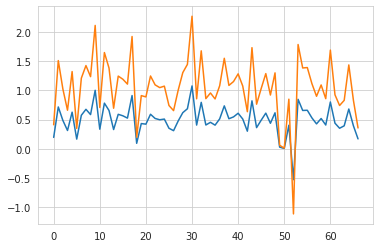

In [15]:
plt.plot(output['cca'].ws[0][:, 78])
plt.plot(output['cca'].ws[0][:, 77])

In [16]:
cell = np.argmin(output['cca'].ws[0][:, 77])
cell

52

In [27]:
x = output['data_trn']['raw']['scabbers_2016-08-31']
y = output['data_trn']['labels']

x.shape, y.shape

((1, 81, 67), (405,))

In [29]:
output['data_trn'].keys()

dict_keys(['raw', 'processed', 'labels', 'df'])

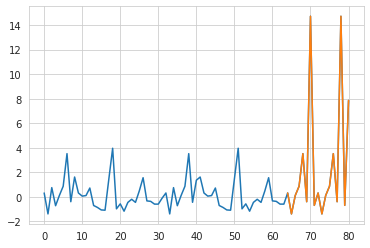

In [32]:
ii = np.where(y[:81] == 1)[0]

plt.plot(x[0, :, cell])
plt.plot(ii, x[0, ii, cell])

### Compare to previous fits

In [70]:
dirs_dict = get_dirs()
run_dir = pjoin(dirs_dict['base_dir'], 'results/svm/v1_l1_full')

start = 30
end = 60
dir_name = next(filter(lambda x: "{:d}:{:d}".format(start, end) in x, os.listdir(run_dir)), None)
load_dir = pjoin(run_dir, dir_name)
df_all = load_dfs(load_dir)

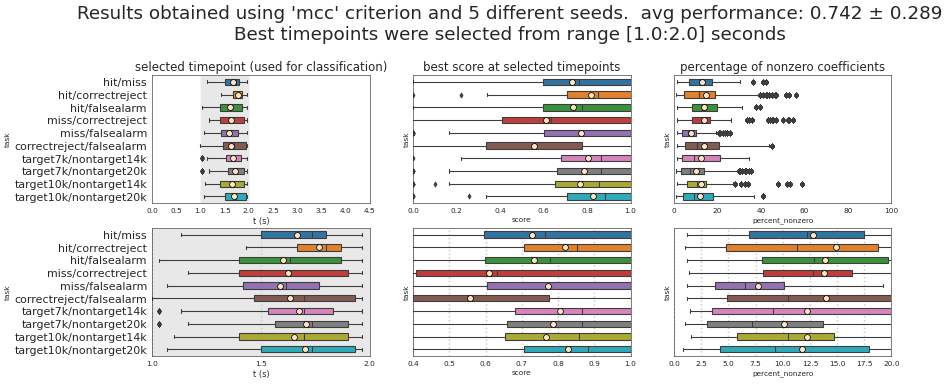

In [74]:
_ = mk_boxplots(
    df_all=df_all,
    criterion='mcc',
    start_time=start,
    end_time=end,
    figsize=(18, 7),
    dpi=53,
)

In [75]:
selected_names = [
    'scabbers_2016-08-31',
    'scabbers_2016-09-07',
    'scabbers_2016-09-22',
    'scabbers_2016-09-23',
    'scabbers_2016-09-28',
]

In [76]:
df_p = df_all['performances']

In [94]:
best_fixed_scores = []
best_overal_scores = []

for name in selected_names:
    df = df_p.loc[
        (df_p.name == name) &
        (df_p.task == 'hit/miss') &
        (df_p.timepoint == 45) &
        (df_p.metric == 'mcc')]
    fixed_time_best_score = df.groupby(['reg_C'], as_index=False).mean().score.max()
    best_fixed_scores.append(fixed_time_best_score)
    
    df = df_p.loc[
        (df_p.name == name) &
        (df_p.task == 'hit/miss') &
        (df_p.metric == 'mcc')]
    best_reg = df.best_reg.unique().item()
    best_timepoint = df.best_timepoint.unique().item()
    
    _df = df.loc[(df.reg_C == best_reg) & (df.timepoint == best_timepoint)]
    best_score = _df.score.mean()
    best_overal_scores.append(best_score)

    best_fixed_scores.append(fixed_time_best_score)
    print(name, best_reg, best_timepoint, best_score, fixed_time_best_score)
    
print('\n\n', np.mean(best_overal_scores), np.mean(best_fixed_scores))

scabbers_2016-08-31 0.008 47 0.419216017507648 0.26936274702822705
scabbers_2016-09-07 0.003 50 0.7941795037550132 0.6615147511217525
scabbers_2016-09-22 0.05 41 0.9384437310486347 1.0
scabbers_2016-09-23 0.005 53 0.6478695440266765 0.6654665838405287
scabbers_2016-09-28 0.008 52 0.6536971191909041 0.43696813250814087


 0.6906811831057753 0.6066624428997298


In [107]:
args.keys()

dict_keys(['seeds', 'min_nb_trials', 'target', 'global_normalize', 'augment_data', 'xv_folds', 'time_range', 'num_ccs', 'cca_regs', 'clf_regs', 'clf_max_iter', 'clf_tol'])

### Lower threshold

In [120]:
results, best, args = fit_cca_loop(
    h_load_file=dirs_dict['h_load_file'],
    save_file='./min_nb_trials=50.df',
    n_seeds=3,
    min_nb_trials=50,
    num_ccs=np.arange(1, 90, 1),
    cca_regs=np.logspace(-4, 0, 20),
    clf_regs=np.logspace(-4, -1, 20),
)


best hyperparams:

n_components:	75,
cca_reg:	1.000e-04,
clf_reg:	3.793e-03,
score:		0.4924




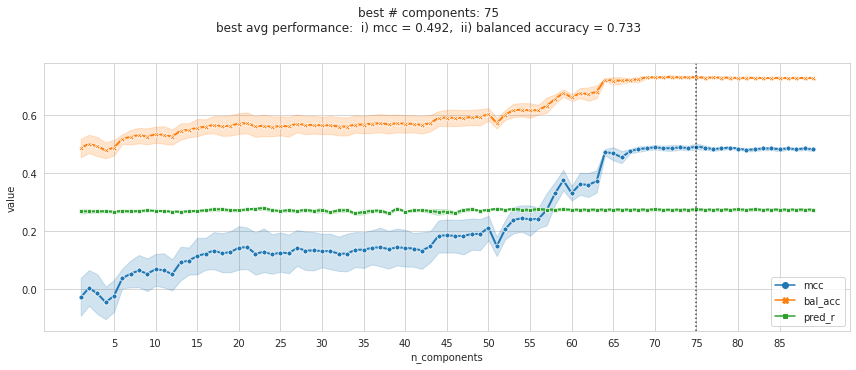

In [125]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 5))

selected_df = results.loc[(results.cca_reg == best['cca_reg']) & (results.clf_reg == best['clf_reg'])]

sns.lineplot(data=selected_df, x='n_components', y='value', hue='metric',
             style='metric', markers=True, dashes=False, lw=2, markersize=5)
plt.xticks([item for item in args['num_ccs'] if item % 5 == 0])
plt.axvline(best['n_component'], ls=':', color='k', alpha=0.7)
plt.legend(loc='lower right')

msg = 'best # components: {:d}\n'
msg += 'best avg performance:  i) mcc = {:.3f},  ii) balanced accuracy = {:.3f}'
avg_mcc = selected_df.loc[(selected_df.metric == 'mcc') &
                          (selected_df.n_components == best['n_component'])].value.mean()
avg_balacc = selected_df.loc[(selected_df.metric == 'bal_acc') &
                             (selected_df.n_components == best['n_component'])].value.mean()
msg = msg.format(best['n_component'], avg_mcc, avg_balacc)
plt.suptitle(msg, fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

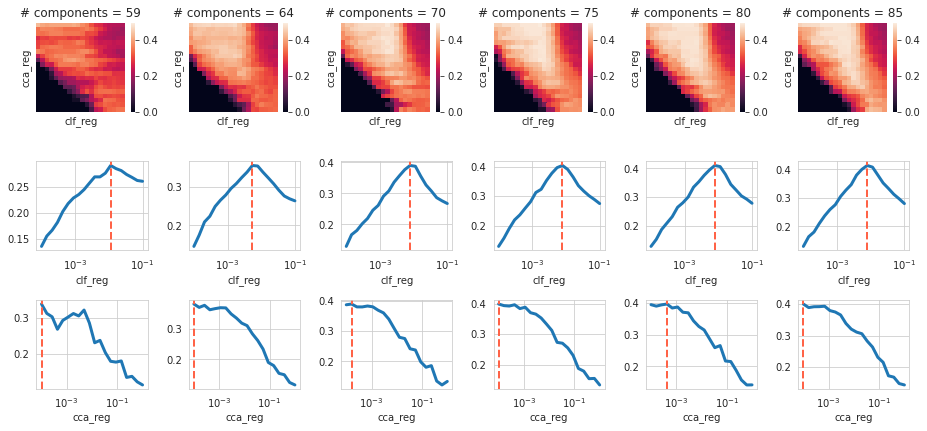

In [128]:
components_to_plot = [59, 64, 70, 75, 80, 85]
fig, axes = plt.subplots(3, len(components_to_plot), figsize=(13, 6))

for idx, cc in enumerate(components_to_plot):
    selected_df = results.loc[(results.n_components == cc) & (results.metric == 'mcc')]  
    df = selected_df.groupby(['cca_reg', 'clf_reg'], as_index=False).mean()
    df = df.pivot(index='cca_reg', columns=['clf_reg'], values='value')
    
    sns.heatmap(data=df, xticklabels=False, yticklabels=False, vmin=0, vmax=best['score'], ax=axes[0, idx])
    axes[0, idx].set_title('# components = {:d}'.format(cc))
    axes[0, idx].set_aspect('equal')

    for i in range(2):
        a = df.mean(i)
        axes[i+1, idx].plot(a, lw=3)
        axes[i+1, idx].axvline(a.index[a.argmax()], lw=2, ls='--', color='tomato')
        axes[i+1, idx].set_xlabel(a.index.name)
        axes[i+1, idx].set_xscale('log')

fig.tight_layout()
plt.show()

## --- New!

In [ ]:
results, best, args = fit_cca_loop(
    h_load_file=dirs_dict['h_load_file'],
    save_file='./min_nb_trials=30.df',
    n_seeds=3,
    min_nb_trials=30,
    num_ccs=range(70, 85),
    cca_regs=np.logspace(-8, 0, 30),
    clf_regs=np.logspace(-5, -1, 30),
)

/home/hadi/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


/home/hadi/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [131]:
output_trn, output_tst = prepare_cca_data(
    h_load_file=dirs_dict['h_load_file'],
    min_nb_trials=50,
    target=True,
    global_normalize=True,
    augment_data=False,
    xv_folds=5,
    which_fold=0,
    time_range=range(45, 46),
    verbose=True,
)

gabby_2016-08-20 (135, 75, 49)
gabby_2016-08-21 (135, 84, 59)
gabby_2016-08-22 (135, 60, 78)
gabby_2016-08-24 (135, 73, 85)
gabby_2016-09-07 (135, 68, 52)
ken_2016-08-20 (135, 65, 54)
ken_2016-08-21 (135, 84, 82)
ken_2016-08-24 (135, 70, 77)
ken_2016-09-22 (135, 74, 68)
ken_2016-09-23 (135, 62, 62)
scabbers_2016-08-18 (135, 68, 46)
scabbers_2016-08-22 (135, 73, 50)
scabbers_2016-08-24 (135, 62, 52)
scabbers_2016-08-31 (135, 100, 67)
scabbers_2016-09-07 (135, 124, 65)
scabbers_2016-09-22 (135, 133, 73)
scabbers_2016-09-23 (135, 110, 62)
scabbers_2016-09-28 (135, 134, 52)


In [134]:
{k: v.shape for k, v in output_trn['raw'].items()}

{'gabby_2016-08-20': (1, 62, 49),
 'gabby_2016-08-21': (1, 68, 59),
 'gabby_2016-08-22': (1, 50, 78),
 'gabby_2016-08-24': (1, 60, 85),
 'gabby_2016-09-07': (1, 56, 52),
 'ken_2016-08-20': (1, 54, 54),
 'ken_2016-08-21': (1, 68, 82),
 'ken_2016-08-24': (1, 57, 77),
 'ken_2016-09-22': (1, 61, 68),
 'ken_2016-09-23': (1, 52, 62),
 'scabbers_2016-08-18': (1, 56, 46),
 'scabbers_2016-08-22': (1, 60, 50),
 'scabbers_2016-08-24': (1, 51, 52),
 'scabbers_2016-08-31': (1, 81, 67),
 'scabbers_2016-09-07': (1, 101, 65),
 'scabbers_2016-09-22': (1, 108, 73),
 'scabbers_2016-09-23': (1, 89, 62),
 'scabbers_2016-09-28': (1, 109, 52)}

In [76]:
df_p = df_all['performances']

In [142]:
best_fixed_scores = []
best_overal_scores = []

for name in output_trn['raw'].keys():
    df = df_p.loc[
        (df_p.name == name) &
        (df_p.task == 'hit/miss') &
        (df_p.timepoint == 45) &
        (df_p.metric == 'mcc')]
    fixed_time_best_score = df.groupby(['reg_C'], as_index=False).mean().score.max()
    best_fixed_scores.append(fixed_time_best_score)
    
    df = df_p.loc[
        (df_p.name == name) &
        (df_p.task == 'hit/miss') &
        (df_p.metric == 'mcc')]
    best_reg = df.best_reg.unique().item()
    best_timepoint = df.best_timepoint.unique().item()
    
    _df = df.loc[(df.reg_C == best_reg) & (df.timepoint == best_timepoint)]
    best_score = _df.score.mean()
    best_overal_scores.append(best_score)

    best_fixed_scores.append(fixed_time_best_score)
    print(name, best_reg, best_timepoint, best_score, fixed_time_best_score)
    
print('\n\n', np.mean(best_overal_scores), np.mean(best_fixed_scores))

gabby_2016-08-20 0.05 45 0.8696799449852968 0.8696799449852968
gabby_2016-08-21 0.005 48 0.45590267869953394 0.3333004673197818
gabby_2016-08-22 0.003 59 0.8834733547569205 0.6645751311064589
gabby_2016-08-24 0.008 56 0.4211047478842489 0.0034483090333273735
gabby_2016-09-07 0.003 41 0.6037361629862457 0.45825756949558405
ken_2016-08-20 0.005 54 0.6036700308869263 0.4
ken_2016-08-21 0.005 43 0.6766640336771411 0.65033937904748
ken_2016-08-24 0.0008 42 0.6414104402550318 0.6377900070463604
ken_2016-09-22 0.008 45 0.4776617392146205 0.4920056583229385
ken_2016-09-23 1.0 54 0.7348399724926484 0.3166581543108302
scabbers_2016-08-18 0.008 48 0.8696799449852968 0.6478108293414642
scabbers_2016-08-22 0.008 59 0.9527525231651947 0.561085856498528
scabbers_2016-08-24 0.008 34 0.3462794598879075 0.30183501544346314
scabbers_2016-08-31 0.008 47 0.419216017507648 0.26936274702822705
scabbers_2016-09-07 0.003 50 0.7941795037550132 0.6615147511217525
scabbers_2016-09-22 0.05 41 0.9384437310486347 1.

### Study clf coefficients

In [148]:
fold = 2

output_trn, output_tst = prepare_cca_data(
    h_load_file=dirs_dict['h_load_file'],
    min_nb_trials=50,
    target=True,
    global_normalize=True,
    augment_data=False,
    xv_folds=5,
    which_fold=fold,
    time_range=range(45, 46),
    verbose=False,
)
train_list, y_trn = output_trn['processed'], output_trn['labels']
test_list, y_tst = output_tst['processed'], output_tst['labels']


cca = rcca.CCA(
    kernelcca=True,
    ktype='linear',
    reg=best['cca_reg'],
    numCC=best['n_component'],
    verbose=False,
)
cca.train([item / np.sqrt(best['n_component']) for item in train_list])
testcorrs = cca.validate(test_list)

corrs = []
for item in testcorrs:
    corrs.append(np.mean(np.abs(item)))
pred_r = np.mean(corrs)


x_trn = [x @ w for x, w in zip(train_list, cca.ws)]
x_tst = [x @ w for x, w in zip(test_list, cca.ws)]
x_trn, x_tst = tuple(map(np.concatenate, [x_trn, x_tst]))


clf = LogisticRegression(
    random_state=42,
    penalty='l1',
    C=best['clf_reg'],
    solver='liblinear',
    class_weight='balanced',
    max_iter=int(1e4),
    tol=1e-6,
).fit(x_trn, y_trn)
y_pred = clf.predict(x_tst)

balacc = balanced_accuracy_score(y_tst, y_pred)
mcc = matthews_corrcoef(y_tst, y_pred)

pred_r, balacc, mcc

(0.2863303003962716, 0.7400815721171672, 0.4995561662691966)

In [149]:
coeffs = clf.coef_.flatten()
coeffs

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.01151475,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.00149195,
       -0.00075647, -0.00104831,  0.00441885,  0.00337783,  0.00174549,
       -0.00098892, -0.00041472, -0.00517937,  0.00292418,  0.00356777,
       -0.00365974, -0.00013444, -0.00369978,  0.        , -0.00248861,
        0.00098472,  0.        ,  0.00117524,  0.        , -0.00

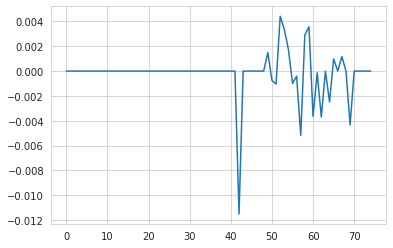

array([42, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65,
       67, 69])

In [150]:
sns.set_style('whitegrid')
plt.plot(coeffs)
nonzero_comps = np.where(coeffs != 0)[0]
plt.show()

nonzero_comps

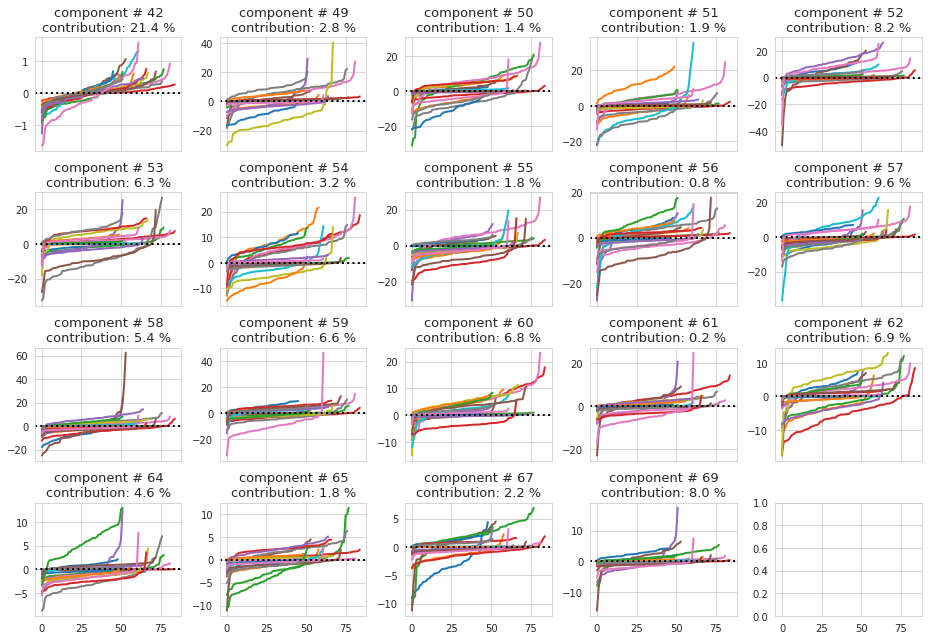

In [161]:
sns.set_style('whitegrid')
nrows = 4
ncols = int(np.ceil(len(nonzero_comps) / nrows))
fig, axes = plt.subplots(nrows, ncols, figsize=(13, 9), sharex='all', sharey='none')

for idx, cc in enumerate(nonzero_comps):
    i, j = idx // ncols, idx % ncols

    for expt_id, w in enumerate(cca.ws):
        axes[i, j].plot(sorted(w[:, cc]), lw=2, label='expt {:d}'.format(expt_id))
    axes[i, j].axhline(0, color='k', lw=2, ls=':')
    # axes[i, j].legend(loc='lower right')
    msg = 'component # {:d}\ncontribution: {:.1f} {:s}'
    msg = msg.format(cc, abs(coeffs[cc]) / sum(abs(coeffs)) * 100, '%')
    axes[i, j].set_title(msg, fontsize=13)

fig.tight_layout()
plt.show()

In [162]:
comps = np.concatenate(cca.comps)
comps.shape

(900, 75)

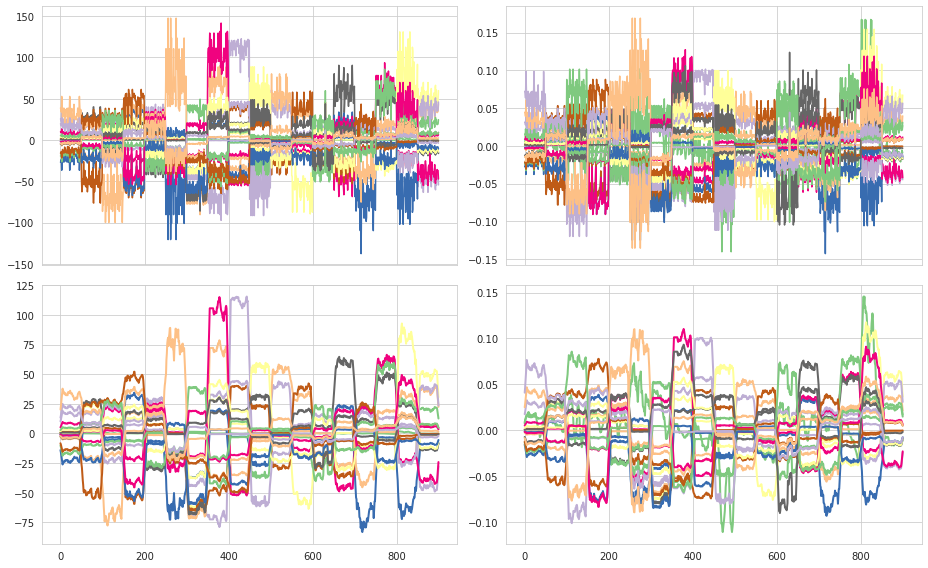

In [165]:
palette = sns.color_palette("Accent", n_colors=len(nonzero_comps))

sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(13, 8), sharex='all', sharey='none')

_data = comps[:, nonzero_comps]
_data_smooth = smoothen(_data.T, filter_sz=10).T
ln = sns.lineplot(data=_data, palette=palette,
                  dashes=False, legend=False, ax=axes[0, 0])
ln = sns.lineplot(data=normalize(_data, axis=0), palette=palette,
                  dashes=False, legend=False, ax=axes[0, 1])
ln = sns.lineplot(data=_data_smooth, palette=palette, lw=2,
                  dashes=False, legend=False, ax=axes[1, 0])
ln = sns.lineplot(data=normalize(_data_smooth, axis=0), palette=palette, lw=2,
                  dashes=False, legend=False, ax=axes[1, 1])

fig.tight_layout()
plt.show()

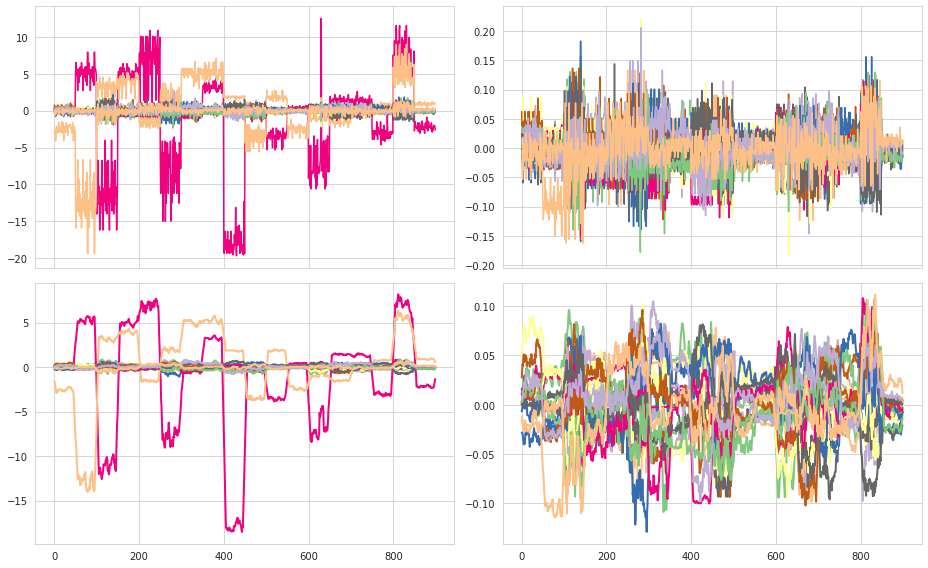

In [166]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(13, 8), sharex='all', sharey='none')

rng = np.random.RandomState(42)
zero_comps = np.where(coeffs == 0)[0]
random_components = rng.choice(zero_comps, size=len(nonzero_comps), replace=False)
_data = comps[:, random_components]
_data_smooth = smoothen(_data.T, filter_sz=10).T
ln = sns.lineplot(data=_data, palette=palette,
                  dashes=False, legend=False, ax=axes[0, 0])
ln = sns.lineplot(data=normalize(_data, axis=0), palette=palette,
                  dashes=False, legend=False, ax=axes[0, 1])
ln = sns.lineplot(data=_data_smooth, palette=palette, lw=2,
                  dashes=False, legend=False, ax=axes[1, 0])
ln = sns.lineplot(data=normalize(_data_smooth, axis=0), palette=palette, lw=2,
                  dashes=False, legend=False, ax=axes[1, 1])

fig.tight_layout()
plt.show()

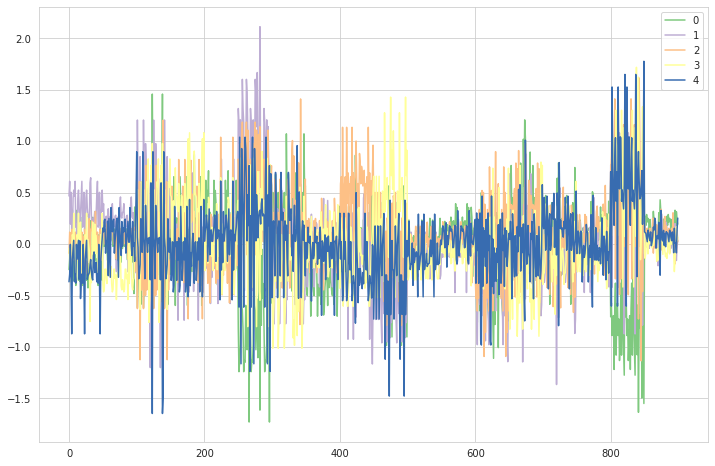

In [167]:
palette = sns.color_palette("Accent", n_colors=5)

plt.figure(figsize=(12, 8))
sns.lineplot(data=comps[:, 20:25], palette=palette, legend='brief', dashes=False);

In [169]:
comps_tst = [x @ w for x, w in zip(output_tst['processed'], cca.ws)]
comps_tst = np.concatenate(comps_tst)
comps_tst.shape

(180, 75)

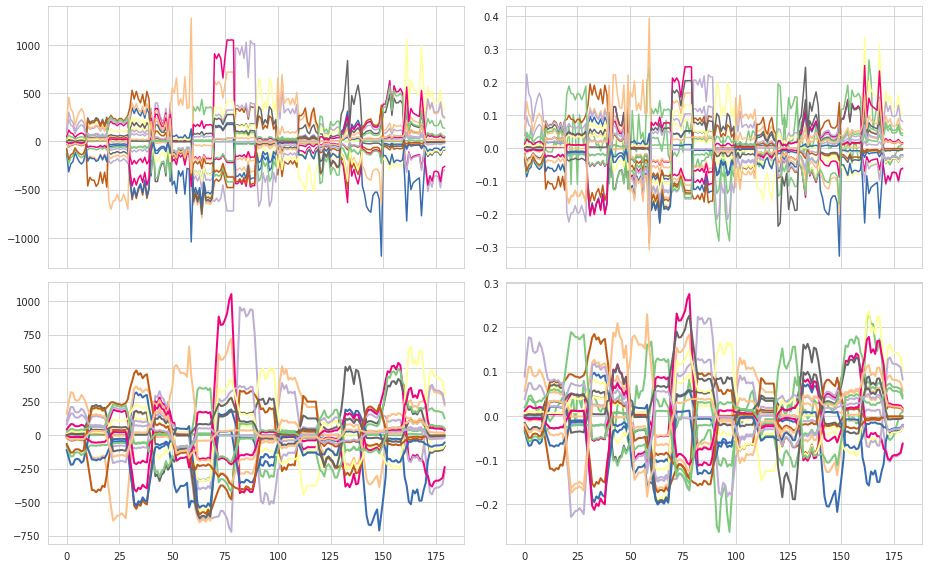

In [173]:
palette = sns.color_palette("Accent", n_colors=len(nonzero_comps))

sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(13, 8), sharex='all', sharey='none')

_data = comps_tst[:, nonzero_comps]
_data_smooth = smoothen(_data.T, filter_sz=4).T
ln = sns.lineplot(data=_data, palette=palette,
                  dashes=False, legend=False, ax=axes[0, 0])
ln = sns.lineplot(data=normalize(_data, axis=0), palette=palette,
                  dashes=False, legend=False, ax=axes[0, 1])
ln = sns.lineplot(data=_data_smooth, palette=palette, lw=2,
                  dashes=False, legend=False, ax=axes[1, 0])
ln = sns.lineplot(data=normalize(_data_smooth, axis=0), palette=palette, lw=2,
                  dashes=False, legend=False, ax=axes[1, 1])

fig.tight_layout()
plt.show()

### Best r and mcc

In [175]:
best_r = extract_best_hyperparams(results, metric='pred_r')

best hyperparams:

n_components:	75,
cca_reg:	1.000e-06,
clf_reg:	1.000e-04,
score:		0.2768




In [179]:
best_r_mcc = extract_best_hyperparams(
    results.loc[
        (results.n_components == best_r['n_component']) &
        (results.cca_reg == best_r['cca_reg'])],
    metric='mcc',
)

best hyperparams:

n_components:	75,
cca_reg:	1.000e-06,
clf_reg:	1.000e-04,
score:		0.4879




In [216]:
results = pd.read_pickle('./min_nb_trials=50_precision.df')

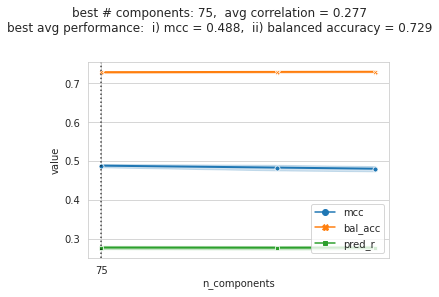

In [218]:
sns.set_style('whitegrid')
plt.figure(figsize=(5, 4))

selected_df = results.loc[(results.cca_reg == best_r_mcc['cca_reg']) & (results.clf_reg == best_r_mcc['clf_reg'])]

sns.lineplot(data=selected_df, x='n_components', y='value', hue='metric',
             style='metric', markers=True, dashes=False, lw=2, markersize=5)
plt.xticks([item for item in args['num_ccs'] if item % 5 == 0])
plt.axvline(best_r_mcc['n_component'], ls=':', color='k', alpha=0.7)
plt.legend(loc='lower right')

msg = 'best # components: {:d},  avg correlation = {:.3f}\n'
msg += 'best avg performance:  i) mcc = {:.3f},  ii) balanced accuracy = {:.3f}'
avg_r = selected_df.loc[(selected_df.metric == 'pred_r') &
                        (selected_df.n_components == best_r_mcc['n_component'])].value.mean()
avg_mcc = selected_df.loc[(selected_df.metric == 'mcc') &
                          (selected_df.n_components == best_r_mcc['n_component'])].value.mean()
avg_balacc = selected_df.loc[(selected_df.metric == 'bal_acc') &
                             (selected_df.n_components == best_r_mcc['n_component'])].value.mean()
msg = msg.format(best_r_mcc['n_component'], avg_r, avg_mcc, avg_balacc)
plt.suptitle(msg, fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

In [180]:
output_trn, output_tst = prepare_cca_data(
    h_load_file=dirs_dict['h_load_file'],
    min_nb_trials=50,
    target=True,
    global_normalize=True,
    augment_data=False,
    xv_folds=5,
    which_fold=0,
    time_range=range(45, 46),
    verbose=True,
)

gabby_2016-08-20 (135, 75, 49)
gabby_2016-08-21 (135, 84, 59)
gabby_2016-08-22 (135, 60, 78)
gabby_2016-08-24 (135, 73, 85)
gabby_2016-09-07 (135, 68, 52)
ken_2016-08-20 (135, 65, 54)
ken_2016-08-21 (135, 84, 82)
ken_2016-08-24 (135, 70, 77)
ken_2016-09-22 (135, 74, 68)
ken_2016-09-23 (135, 62, 62)
scabbers_2016-08-18 (135, 68, 46)
scabbers_2016-08-22 (135, 73, 50)
scabbers_2016-08-24 (135, 62, 52)
scabbers_2016-08-31 (135, 100, 67)
scabbers_2016-09-07 (135, 124, 65)
scabbers_2016-09-22 (135, 133, 73)
scabbers_2016-09-23 (135, 110, 62)
scabbers_2016-09-28 (135, 134, 52)


In [181]:
{k: v.shape for k, v in output_trn['raw'].items()}

{'gabby_2016-08-20': (1, 62, 49),
 'gabby_2016-08-21': (1, 68, 59),
 'gabby_2016-08-22': (1, 50, 78),
 'gabby_2016-08-24': (1, 60, 85),
 'gabby_2016-09-07': (1, 56, 52),
 'ken_2016-08-20': (1, 54, 54),
 'ken_2016-08-21': (1, 68, 82),
 'ken_2016-08-24': (1, 57, 77),
 'ken_2016-09-22': (1, 61, 68),
 'ken_2016-09-23': (1, 52, 62),
 'scabbers_2016-08-18': (1, 56, 46),
 'scabbers_2016-08-22': (1, 60, 50),
 'scabbers_2016-08-24': (1, 51, 52),
 'scabbers_2016-08-31': (1, 81, 67),
 'scabbers_2016-09-07': (1, 101, 65),
 'scabbers_2016-09-22': (1, 108, 73),
 'scabbers_2016-09-23': (1, 89, 62),
 'scabbers_2016-09-28': (1, 109, 52)}

In [182]:
df_p = df_all['performances']

In [183]:
best_fixed_scores = []
best_overal_scores = []

for name in output_trn['raw'].keys():
    df = df_p.loc[
        (df_p.name == name) &
        (df_p.task == 'hit/miss') &
        (df_p.timepoint == 45) &
        (df_p.metric == 'mcc')]
    fixed_time_best_score = df.groupby(['reg_C'], as_index=False).mean().score.max()
    best_fixed_scores.append(fixed_time_best_score)
    
    df = df_p.loc[
        (df_p.name == name) &
        (df_p.task == 'hit/miss') &
        (df_p.metric == 'mcc')]
    best_reg = df.best_reg.unique().item()
    best_timepoint = df.best_timepoint.unique().item()
    
    _df = df.loc[(df.reg_C == best_reg) & (df.timepoint == best_timepoint)]
    best_score = _df.score.mean()
    best_overal_scores.append(best_score)

    best_fixed_scores.append(fixed_time_best_score)
    print(name, best_reg, best_timepoint, best_score, fixed_time_best_score)
    
print('\n\n', np.mean(best_overal_scores), np.mean(best_fixed_scores))

gabby_2016-08-20 0.05 45 0.8696799449852968 0.8696799449852968
gabby_2016-08-21 0.005 48 0.45590267869953394 0.3333004673197818
gabby_2016-08-22 0.003 59 0.8834733547569205 0.6645751311064589
gabby_2016-08-24 0.008 56 0.4211047478842489 0.0034483090333273735
gabby_2016-09-07 0.003 41 0.6037361629862457 0.45825756949558405
ken_2016-08-20 0.005 54 0.6036700308869263 0.4
ken_2016-08-21 0.005 43 0.6766640336771411 0.65033937904748
ken_2016-08-24 0.0008 42 0.6414104402550318 0.6377900070463604
ken_2016-09-22 0.008 45 0.4776617392146205 0.4920056583229385
ken_2016-09-23 1.0 54 0.7348399724926484 0.3166581543108302
scabbers_2016-08-18 0.008 48 0.8696799449852968 0.6478108293414642
scabbers_2016-08-22 0.008 59 0.9527525231651947 0.561085856498528
scabbers_2016-08-24 0.008 34 0.3462794598879075 0.30183501544346314
scabbers_2016-08-31 0.008 47 0.419216017507648 0.26936274702822705
scabbers_2016-09-07 0.003 50 0.7941795037550132 0.6615147511217525
scabbers_2016-09-22 0.05 41 0.9384437310486347 1.

### Study clf coefficients

In [193]:
fold = 4

output_trn, output_tst = prepare_cca_data(
    h_load_file=dirs_dict['h_load_file'],
    min_nb_trials=50,
    target=True,
    global_normalize=True,
    augment_data=False,
    xv_folds=5,
    which_fold=fold,
    time_range=range(45, 46),
    verbose=False,
)
train_list, y_trn = output_trn['processed'], output_trn['labels']
test_list, y_tst = output_tst['processed'], output_tst['labels']


cca = rcca.CCA(
    kernelcca=True,
    ktype='linear',
    reg=best_r_mcc['cca_reg'],
    numCC=best_r_mcc['n_component'],
    verbose=False,
)
cca.train([item / np.sqrt(best_r_mcc['n_component']) for item in train_list])
testcorrs = cca.validate(test_list)

corrs = []
for item in testcorrs:
    corrs.append(np.mean(np.abs(item)))
pred_r = np.mean(corrs)


x_trn = [x @ w for x, w in zip(train_list, cca.ws)]
x_tst = [x @ w for x, w in zip(test_list, cca.ws)]
x_trn, x_tst = tuple(map(np.concatenate, [x_trn, x_tst]))


clf = LogisticRegression(
    random_state=42,
    penalty='l1',
    C=best_r_mcc['clf_reg'],
    solver='liblinear',
    class_weight='balanced',
    max_iter=int(1e4),
    tol=1e-6,
).fit(x_trn, y_trn)
y_pred = clf.predict(x_tst)

balacc = balanced_accuracy_score(y_tst, y_pred)
mcc = matthews_corrcoef(y_tst, y_pred)

pred_r, balacc, mcc

(0.26529376053263953, 0.7332220986281053, 0.49877753333740393)

In [194]:
coeffs = clf.coef_.flatten()
coeffs

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  6.18601605e-05,  1.22338249e-04,  2.11300017e-05,
       -4.91994579e-05, -

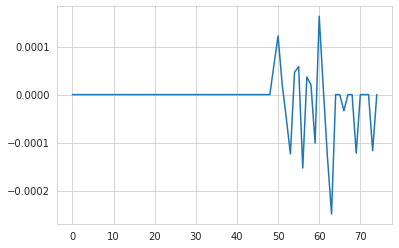

array([49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 66, 69,
       73])

In [195]:
sns.set_style('whitegrid')
plt.plot(coeffs)
nonzero_comps = np.where(coeffs != 0)[0]
plt.show()

nonzero_comps

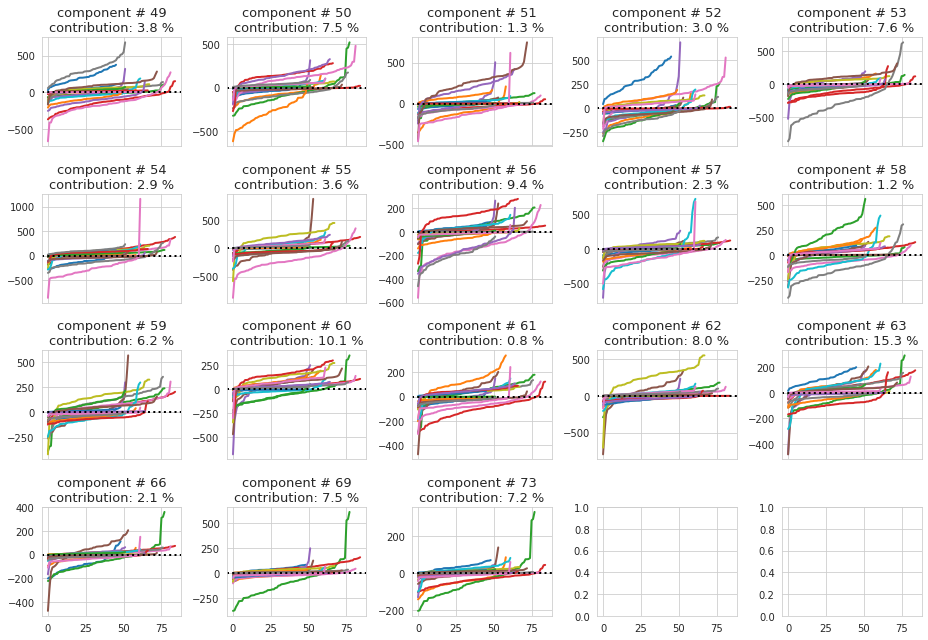

In [196]:
sns.set_style('whitegrid')
nrows = 4
ncols = int(np.ceil(len(nonzero_comps) / nrows))
fig, axes = plt.subplots(nrows, ncols, figsize=(13, 9), sharex='all', sharey='none')

for idx, cc in enumerate(nonzero_comps):
    i, j = idx // ncols, idx % ncols

    for expt_id, w in enumerate(cca.ws):
        axes[i, j].plot(sorted(w[:, cc]), lw=2, label='expt {:d}'.format(expt_id))
    axes[i, j].axhline(0, color='k', lw=2, ls=':')
    # axes[i, j].legend(loc='lower right')
    msg = 'component # {:d}\ncontribution: {:.1f} {:s}'
    msg = msg.format(cc, abs(coeffs[cc]) / sum(abs(coeffs)) * 100, '%')
    axes[i, j].set_title(msg, fontsize=13)

fig.tight_layout()
plt.show()

In [197]:
comps = np.concatenate(cca.comps)
comps.shape

(900, 75)

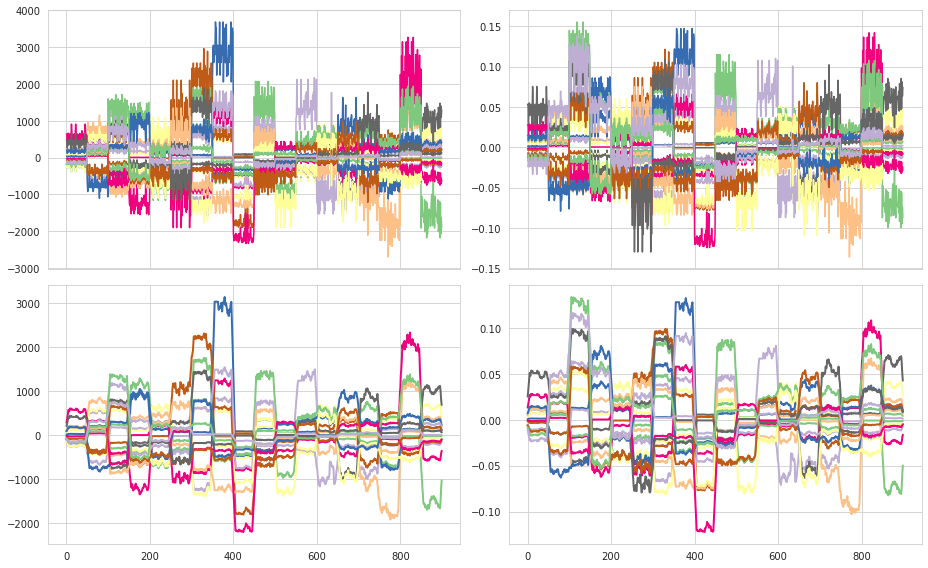

In [198]:
palette = sns.color_palette("Accent", n_colors=len(nonzero_comps))

sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(13, 8), sharex='all', sharey='none')

_data = comps[:, nonzero_comps]
_data_smooth = smoothen(_data.T, filter_sz=10).T
ln = sns.lineplot(data=_data, palette=palette,
                  dashes=False, legend=False, ax=axes[0, 0])
ln = sns.lineplot(data=normalize(_data, axis=0), palette=palette,
                  dashes=False, legend=False, ax=axes[0, 1])
ln = sns.lineplot(data=_data_smooth, palette=palette, lw=2,
                  dashes=False, legend=False, ax=axes[1, 0])
ln = sns.lineplot(data=normalize(_data_smooth, axis=0), palette=palette, lw=2,
                  dashes=False, legend=False, ax=axes[1, 1])

fig.tight_layout()
plt.show()

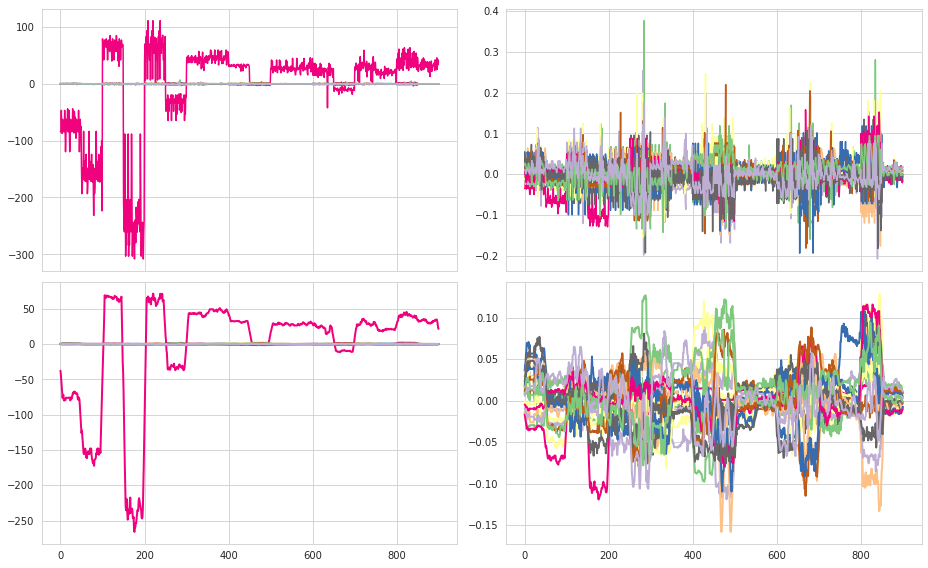

In [199]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(13, 8), sharex='all', sharey='none')

rng = np.random.RandomState(42)
zero_comps = np.where(coeffs == 0)[0]
random_components = rng.choice(zero_comps, size=len(nonzero_comps), replace=False)
_data = comps[:, random_components]
_data_smooth = smoothen(_data.T, filter_sz=10).T
ln = sns.lineplot(data=_data, palette=palette,
                  dashes=False, legend=False, ax=axes[0, 0])
ln = sns.lineplot(data=normalize(_data, axis=0), palette=palette,
                  dashes=False, legend=False, ax=axes[0, 1])
ln = sns.lineplot(data=_data_smooth, palette=palette, lw=2,
                  dashes=False, legend=False, ax=axes[1, 0])
ln = sns.lineplot(data=normalize(_data_smooth, axis=0), palette=palette, lw=2,
                  dashes=False, legend=False, ax=axes[1, 1])

fig.tight_layout()
plt.show()

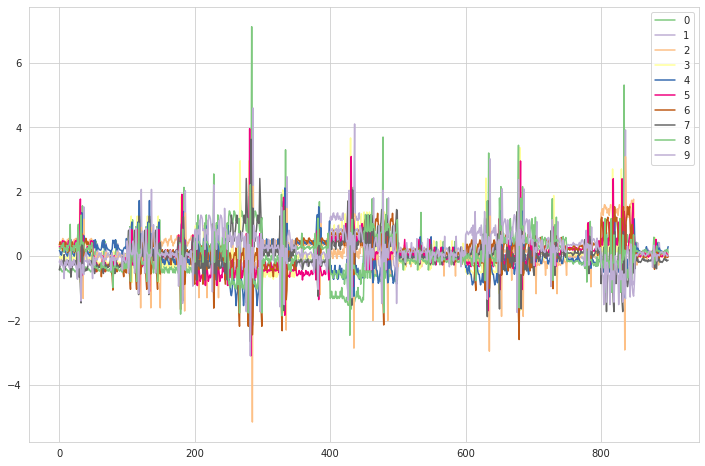

In [202]:
palette = sns.color_palette("Accent", n_colors=10)

plt.figure(figsize=(12, 8))
sns.lineplot(data=comps[:, :10], palette=palette, legend='brief', dashes=False);

In [203]:
comps_tst = [x @ w for x, w in zip(output_tst['processed'], cca.ws)]
comps_tst = np.concatenate(comps_tst)
comps_tst.shape

(180, 75)

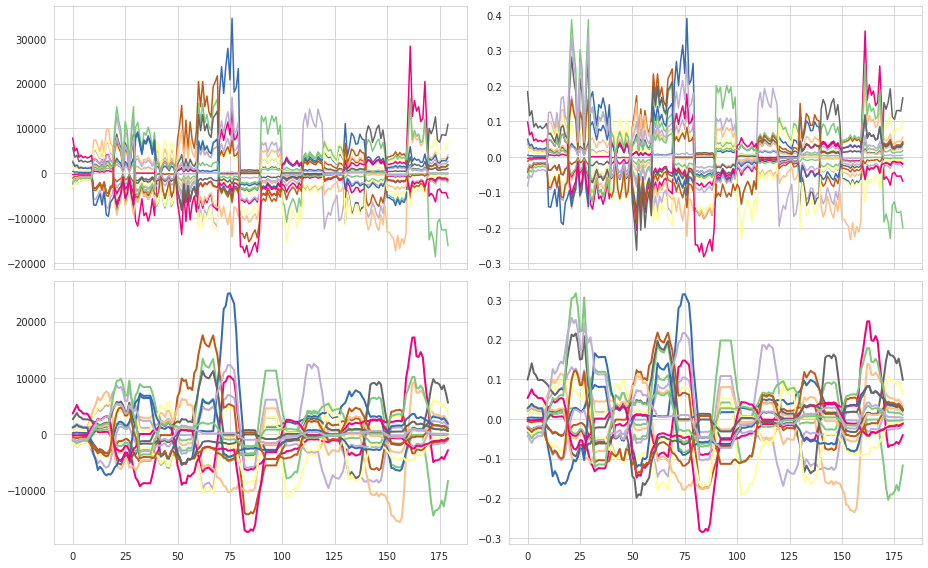

In [219]:
palette = sns.color_palette("Accent", n_colors=len(nonzero_comps))

sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(13, 8), sharex='all', sharey='none')

_data = comps_tst[:, nonzero_comps]
_data_smooth = smoothen(_data.T, filter_sz=5).T
ln = sns.lineplot(data=_data, palette=palette,
                  dashes=False, legend=False, ax=axes[0, 0])
ln = sns.lineplot(data=normalize(_data, axis=0), palette=palette,
                  dashes=False, legend=False, ax=axes[0, 1])
ln = sns.lineplot(data=_data_smooth, palette=palette, lw=2,
                  dashes=False, legend=False, ax=axes[1, 0])
ln = sns.lineplot(data=normalize(_data_smooth, axis=0), palette=palette, lw=2,
                  dashes=False, legend=False, ax=axes[1, 1])

fig.tight_layout()
plt.show()

---
## Draft (ignore below this line)
---

In [4]:


def augment_data(
    x: np.ndarray,
    y: np.ndarray,
    nb_end_samples: int,
    sigma: float = 1.0,
    rng: np.random.RandomState = None,):
    
    nb_samples, nb_features = x.shape

    if nb_end_samples - nb_samples <= 0:
        output = {
            'x_aug': x[:nb_end_samples],
            'y_aug': y[:nb_end_samples],
            'noise': None,
            'indxs': None,
        }
        return output
    else:
        nb_repeats, nb_extra_samples = nb_end_samples//nb_samples, nb_end_samples%nb_samples

    indxs = np.arange(nb_samples)
    x_aug, y_aug = tuple(map(dc, [x, y]))

    for _ in range(1, nb_repeats):
        indxs = np.concatenate([indxs, np.arange(nb_samples)])
        x_aug = np.concatenate([x_aug, x])
        y_aug = np.concatenate([y_aug, y])

    rng = np.random.RandomState(42) if rng is None else rng
    if nb_extra_samples > 0:
        extra_indxs = rng.choice(range(nb_samples), size=nb_extra_samples, replace=True)
        indxs = np.concatenate([indxs, extra_indxs])
        x_aug = np.concatenate([x_aug, x[extra_indxs]])
        y_aug = np.concatenate([y_aug, y[extra_indxs]])

    noise = np.random.randn(*x_aug.shape) * x.std(0) * sigma
    noise[:nb_samples] = 0.0

    augmented = {
        'x_aug': x_aug + noise,
        'y_aug': y_aug,
        'noise': noise,
        'indxs': indxs,
    }
    return augmented

    
def prepare_data(
    h_load_file: str,
    timepoint: int = 45,
    nb_min_samples: int = -1,
    nb_end_samples: int = None,
    augment: bool = False,
    sigma: float = 0.0,
    xv_folds: int = 10,
    random_state: int = 42,):
    
    raw_data = _load_target_nontarget(h_load_file)
    rng = np.random.RandomState(random_state)
    
    train_data, test_data = {}, {}
    train_labels, test_labels = {}, {}
    for key, val in raw_data['target_dffs'].items():
        x = val[timepoint]
        num_samples = len(x)
        if num_samples < nb_min_samples:
            continue

        labels = raw_data['target_labels'][key]
        if not augment:
            x = x[:nb_min_samples]
            labels = labels[:nb_min_samples]

        ### TODDO: floor or ceil?
            
        pos_indxs = np.where(labels == 0)[0]
        neg_indxs = np.where(labels == 1)[0]
        pos_tst_indxs = rng.choice(pos_indxs, size=int(np.ceil(len(pos_indxs)/xv_folds)), replace=False)
        neg_tst_indxs = rng.choice(neg_indxs, size=int(np.ceil(len(neg_indxs)/xv_folds)), replace=False)
        tst_indxs = np.concatenate([pos_tst_indxs, neg_tst_indxs])
        trn_indxs = np.delete(range(len(labels)), tst_indxs)
        assert not set(tst_indxs).intersection(set(trn_indxs))

        test_data[key] = x[tst_indxs]
        train_data[key] = x[trn_indxs]
        test_labels[key] = labels[tst_indxs]
        train_labels[key] = labels[trn_indxs]
    
    aug_train_data = {}
    aug_train_labels = {}
    if augment:
        for key, x in train_data.items():
            y = train_labels[key]
            augmented = augment_data(
                x=x,
                y=y,
                nb_end_samples=nb_end_samples,
                sigma=sigma,
                rng=rng,
            )
            aug_train_data[key] = augmented['x_aug']
            aug_train_labels[key] = augmented['y_aug']
    
    output = {
        'aug_train_data': aug_train_data,
        'aug_train_labels': aug_train_labels,
        'train_data': train_data,
        'train_labels': train_labels,
        'test_data': test_data,
        'test_labels': test_labels,
    }
    return output

In [18]:
[item.shape for item in a['target_freqs'].values()]

[(23,),
 (30,),
 (75,),
 (84,),
 (60,),
 (73,),
 (68,),
 (19,),
 (12,),
 (41,),
 (25,),
 (28,),
 (65,),
 (84,),
 (18,),
 (70,),
 (21,),
 (74,),
 (62,),
 (38,),
 (31,),
 (23,),
 (43,),
 (49,),
 (33,),
 (30,),
 (68,),
 (73,),
 (62,),
 (100,),
 (124,),
 (133,),
 (110,),
 (134,)]

In [3]:
import rcca
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef, f1_score

import random
from tqdm.notebook import tqdm

In [4]:
max_components = 100
seeds = [np.power(2, i) for i in range(30)]
seeds += [42]

results = pd.DataFrame()

for seed in tqdm(seeds):
    random.seed(seed)
    np.random.seed(seed)
    
    output = prepare_data(
        h_load_file=dirs_dict['h_load_file'],
        timepoint=45,
        augment=False,
        nb_min_samples=100,
        random_state=seed,
    )
    train_data = output['train_data']
    train_labels = output['train_labels']
    test_data = output['test_data']
    test_labels = output['test_labels']
    
    for n_components in tqdm(range(1, max_components), leave=False):
        cca = rcca.CCA(reg=1., numCC=n_components, verbose=False)
        cca.train(list(train_data.values()))
        ev = cca.compute_ev(list(test_data.values()))

        x_trn = [x @ w for x, w in zip(train_data.values(), cca.ws)]
        x_tst = [x @ w for x, w in zip(test_data.values(), cca.ws)]    
        y_trn = [item for item in train_labels.values()]
        y_tst = [item for item in test_labels.values()]
        x_trn, x_tst, y_trn, y_tst = tuple(map(np.concatenate, [x_trn, x_tst, y_trn, y_tst]))

        clf = LogisticRegression(
            random_state=seed,
            penalty='l1',
            C=1.,
            solver='liblinear',
            class_weight='balanced',
            max_iter=int(1e6),
        ).fit(x_trn, y_trn)
        y_pred = clf.predict(x_tst)

        balacc = balanced_accuracy_score(y_tst, y_pred)
        f1 = f1_score(y_tst, y_pred)
        mcc = matthews_corrcoef(y_tst, y_pred)

        data_dict = {
            'seed': [seed] * 4,
            'sigma': [np.nan] * 4,
            'n_components': [n_components] * 4,
            'metric': ['mcc', 'f1', 'balacc', 'ev'],
            'value': [mcc, balacc, f1, np.mean([item.max(0).mean() for item in ev])],
        }
        results = pd.concat([results, pd.DataFrame.from_dict(data_dict)])

results = reset_df(results)

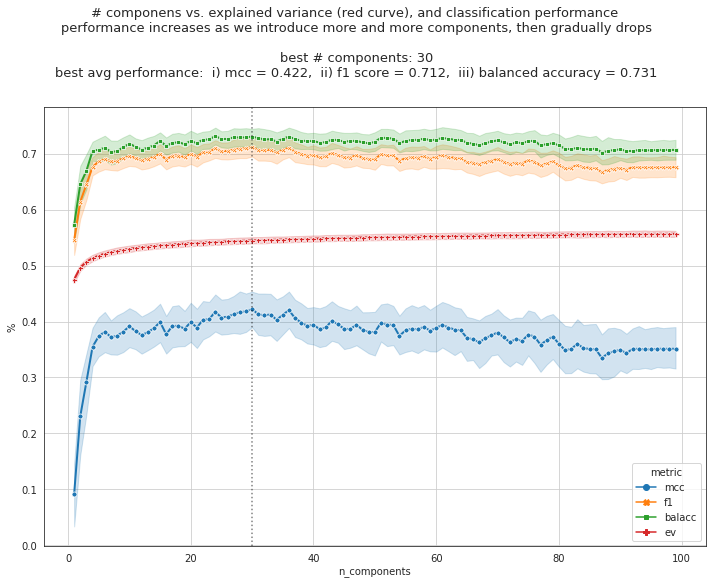

In [5]:
plt.figure(figsize=(10, 8))
sns.lineplot(data=results, x='n_components', y='value', hue='metric',
             style='metric', markers=True, dashes=False, lw=2, markersize=5)
plt.ylabel('%')
plt.grid()

selected_df = results.loc[results.metric == 'mcc']
performance = selected_df.groupby('n_components').mean()
best_n_components = performance.iloc[performance.value.argmax()].name
selected_df = selected_df.loc[selected_df.n_components == best_n_components]

plt.axvline(best_n_components, ls=':', color='k', alpha=0.5)

msg = '# componens vs. explained variance (red curve), and classification performance \n'
msg += 'performance increases as we introduce more and more components, then gradually drops\n\n'
msg += 'best # components: {:d}\n'
msg += 'best avg performance:  i) mcc = {:.3f},  ii) f1 score = {:.3f},  iii) balanced accuracy = {:.3f}'
avg_mcc = results.loc[(results.metric == 'mcc') & (results.n_components == best_n_components)].value.mean()
avg_f1 = results.loc[(results.metric == 'f1') & (results.n_components == best_n_components)].value.mean()
avg_balacc = results.loc[(results.metric == 'balacc') & (results.n_components == best_n_components)].value.mean()
msg = msg.format(best_n_components, avg_mcc, avg_f1, avg_balacc)
plt.suptitle(msg, fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

In [6]:
selected_df

seed  sigma  n_components metric     value
116            1    NaN            30    mcc  0.382679
512            2    NaN            30    mcc  0.478061
908            4    NaN            30    mcc  0.488662
1304           8    NaN            30    mcc  0.368924
1700          16    NaN            30    mcc  0.382679
2096          32    NaN            30    mcc  0.392532
2492          64    NaN            30    mcc  0.482527
2888         128    NaN            30    mcc  0.448464
3284         256    NaN            30    mcc  0.309343
3680         512    NaN            30    mcc  0.341797
4076        1024    NaN            30    mcc  0.404570
4472        2048    NaN            30    mcc  0.644021
4868        4096    NaN            30    mcc  0.497349
5264        8192    NaN            30    mcc  0.488662
5660       16384    NaN            30    mcc  0.522093
6056       32768    NaN            30    mcc  0.435077
6452       65536    NaN            30    mcc  0.465965
6848      131072    NaN            30    mcc  0.204007
7244      262144    NaN            30    mcc  0.374836
7640      524288    NaN            30    mcc  0.404570
8036     1048576    NaN            30    mcc  0.552419
8432     2097152    NaN            30    mcc  0.522093
8828     4194304    NaN            30    mcc  0.350678
9224     8388608    NaN            30    mcc  0.334677
9620    16777216    NaN            30    mcc  0.392532
10016   33554432    NaN            30    mcc  0.539398
10412   67108864    NaN            30    mcc  0.301207
10808  134217728    NaN            30    mcc  0.341797
11204  268435456    NaN            30    mcc  0.254441
11600  536870912    NaN            30    mcc  0.465965
11996         42    NaN            30    mcc  0.522093

### now aug

In [7]:
max_components = 40
seeds = [np.power(2, i) for i in range(30)]
seeds += [42]

results = pd.DataFrame()

for seed in tqdm(seeds):
    random.seed(seed)
    np.random.seed(seed)
    
    output = prepare_data(
        h_load_file=dirs_dict['h_load_file'],
        timepoint=45,
        augment=True,
        sigma=0.3,
        nb_end_samples=130,
        nb_min_samples=100,
        random_state=seed,
    )
    aug_train_data = output['aug_train_data']
    # aug_train_labels = output['aug_train_labels']
    train_data = output['train_data']
    train_labels = output['train_labels']
    test_data = output['test_data']
    test_labels = output['test_labels']
    
    for n_components in tqdm(range(1, max_components), leave=False):
        cca = rcca.CCA(reg=1., numCC=n_components, verbose=False)
        cca.train(list(aug_train_data.values()))
        # ev = cca.compute_ev(list(test_data.values()))

        x_trn = [x @ w for x, w in zip(train_data.values(), cca.ws)]
        x_tst = [x @ w for x, w in zip(test_data.values(), cca.ws)]    
        y_trn = [item for item in train_labels.values()]
        y_tst = [item for item in test_labels.values()]
        x_trn, x_tst, y_trn, y_tst = tuple(map(np.concatenate, [x_trn, x_tst, y_trn, y_tst]))

        clf = LogisticRegression(
            random_state=seed,
            penalty='l1',
            C=1.,
            solver='liblinear',
            class_weight='balanced',
            max_iter=int(1e6),
        ).fit(x_trn, y_trn)
        y_pred = clf.predict(x_tst)

        balacc = balanced_accuracy_score(y_tst, y_pred)
        f1 = f1_score(y_tst, y_pred)
        mcc = matthews_corrcoef(y_tst, y_pred)

        data_dict = {
            'seed': [seed] * 3,
            'sigma': [np.nan] * 3,
            'n_components': [n_components] * 3,
            'metric': ['mcc', 'f1', 'balacc'],
            'value': [mcc, balacc, f1],
        }
        results = pd.concat([results, pd.DataFrame.from_dict(data_dict)])

results = reset_df(results)

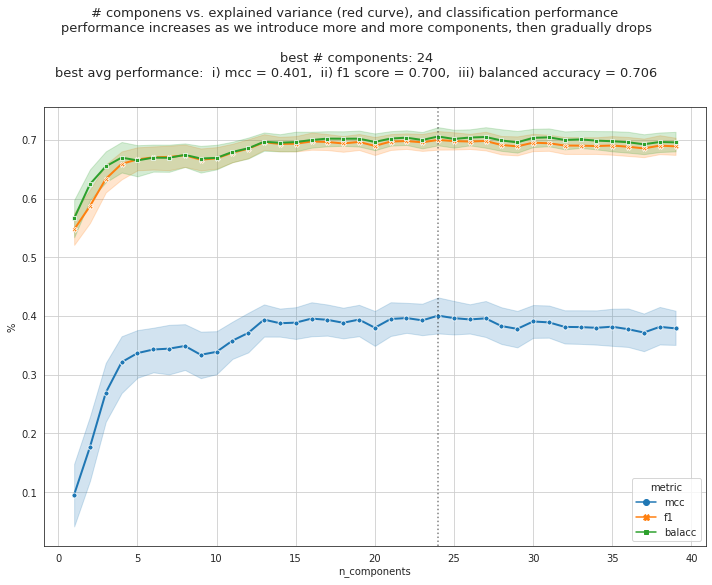

In [8]:
plt.figure(figsize=(10, 8))
sns.lineplot(data=results, x='n_components', y='value', hue='metric',
             style='metric', markers=True, dashes=False, lw=2, markersize=5)
plt.ylabel('%')
plt.grid()

selected_df = results.loc[results.metric == 'mcc']
performance = selected_df.groupby('n_components').mean()
best_n_components = performance.iloc[performance.value.argmax()].name
selected_df = selected_df.loc[selected_df.n_components == best_n_components]

plt.axvline(best_n_components, ls=':', color='k', alpha=0.5)

msg = '# componens vs. explained variance (red curve), and classification performance \n'
msg += 'performance increases as we introduce more and more components, then gradually drops\n\n'
msg += 'best # components: {:d}\n'
msg += 'best avg performance:  i) mcc = {:.3f},  ii) f1 score = {:.3f},  iii) balanced accuracy = {:.3f}'
avg_mcc = results.loc[(results.metric == 'mcc') & (results.n_components == best_n_components)].value.mean()
avg_f1 = results.loc[(results.metric == 'f1') & (results.n_components == best_n_components)].value.mean()
avg_balacc = results.loc[(results.metric == 'balacc') & (results.n_components == best_n_components)].value.mean()
msg = msg.format(best_n_components, avg_mcc, avg_f1, avg_balacc)
plt.suptitle(msg, fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

In [9]:
selected_df

seed  sigma  n_components metric     value
69            1    NaN            24    mcc  0.288944
186           2    NaN            24    mcc  0.432512
303           4    NaN            24    mcc  0.513300
420           8    NaN            24    mcc  0.269125
537          16    NaN            24    mcc  0.316980
654          32    NaN            24    mcc  0.465849
771          64    NaN            24    mcc  0.379787
888         128    NaN            24    mcc  0.470824
1005        256    NaN            24    mcc  0.459796
1122        512    NaN            24    mcc  0.396239
1239       1024    NaN            24    mcc  0.603442
1356       2048    NaN            24    mcc  0.442594
1473       4096    NaN            24    mcc  0.248285
1590       8192    NaN            24    mcc  0.373899
1707      16384    NaN            24    mcc  0.316980
1824      32768    NaN            24    mcc  0.465849
1941      65536    NaN            24    mcc  0.485517
2058     131072    NaN            24    mcc  0.324138
2175     262144    NaN            24    mcc  0.423136
2292     524288    NaN            24    mcc  0.470824
2409    1048576    NaN            24    mcc  0.436706
2526    2097152    NaN            24    mcc  0.459796
2643    4194304    NaN            24    mcc  0.505401
2760    8388608    NaN            24    mcc  0.359864
2877   16777216    NaN            24    mcc  0.202610
2994   33554432    NaN            24    mcc  0.316980
3111   67108864    NaN            24    mcc  0.261084
3228  134217728    NaN            24    mcc  0.432512
3345  268435456    NaN            24    mcc  0.369458
3462  536870912    NaN            24    mcc  0.436706
3579         42    NaN            24    mcc  0.495567